# **Analyze the Influence of Crime Types on the Arrest Rate in Various Areas of Chicago from 2002 to 2023**

# Project 1

## 1.1 Introduction

Crime is a complex and multifaceted issue that has significant implications for public safety and community well-being. In general, Crime could be divided into two types, violent and non-violent crime; furthermore, crimes like "Homicide", "Assault", and "Robbery" are considered violent, while crimes like "Theft" and "Property damage" are non-violent. Ousey (2000) discusses that declining economic status increases poverty rates and population movements like new immigrants, and leads to rising crime rates. The city of Chicago, like many urban centers, experiences a diverse range of criminal activities. Therefore, Chicago has been grappling with crime-related concerns, and understanding the factors influencing arrest rates can offer valuable insights into effective law enforcement strategies and community safety. This dataset reference is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system and hosted in Google BigQuery, which contains incidents of crime except murders that occurred in the city of Chicago from 2001 to 2024.

Braga et al. (2012) suggest that robbery incidents were highly concentrated in a small number of street units, and that these units exhibited different trends over time depending on the type of robbery (street, commercial, or other). Hence, I am wondering whether other types of crime would likely take place in only certain community areas, and what factors cause it. Moreover, Wilson (1987) discusses that disadvantaged communities experience disproportionately high levels of unemployment, inadequate educational opportunities, and limited access to essential resources, which fosters an environment conducive to crime. Therefore, I am going to start with per capita income to observe the relationship between the number of crimes and the arrest rate caused by economic factors.

This project seeks to analyze the relationship between different crime types and areas of Chicago and the arrest rate from 2002 to 2023. Also, I will explore the influence of some economic factors on different crime types in various regions, contributing to our understanding of the nuanced factors affecting arrest rates in Chicago. Throughout my analysis, I will employ statistical tools, including histograms, box plots, and line charts, to visually represent the relationships between crime types, time, locations, and arrest rates. These visualizations will provide valuable insights into patterns and trends within the dataset.

The outcome of this project is arrest rate and there are three independent variables, crime types, time and location. For the first variable ($X_1$), there are 35 crime types in the dataset. The second variable ($X_2$) is the community area which includes 77 areas where the incident occurred in Chicago. The last variable ($X_3$) is the time from 2002 to 2023. The type of crime in a given area can significantly affect law enforcement strategies, community safety perceptions, and arrest rates. In addition, factors such as socioeconomic conditions, population density, and community policing strategies may contribute to differences in arrest rates across locations. Hence, after this research, I could understand how different crime types and locations relate to arrest rates with the change of time, and so learn more about Chicago's crime dynamics. However, it is essential to acknowledge the limitations inherent in this study, such as potential data constraints and external factors influencing crime dynamics.

## 1.2 Data Cleaning and Loading

Before summarising, I need to clean our original dataset first. In this section, I will drop some columns that are useless to my research, such as 'ICUR', 'Domestic', 'Beat', and 'Ward'. Also, there are some incidents that do not keep detailed records, so we need to clean those data to get a more complete dataset, called 'chicago_crime_clean'. To keep the data clean, we change the data of 'District' and 'Community Area' from float to integer.

In [37]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point

In [42]:
relative_path = os.path.join('..', 'Data', 'Chicago_Crime.csv')
abs_path = os.path.abspath(relative_path)

# Read the CSV file
chicago_crime = pd.read_csv(abs_path)

In [4]:
chicago_crime.shape

(7983700, 22)

In [5]:
chicago_crime.isnull().any(axis=0)

ID                      False
Case Number             False
Date                    False
Block                   False
IUCR                    False
Primary Type            False
Description             False
Location Description     True
Arrest                  False
Domestic                False
Beat                    False
District                 True
Ward                     True
Community Area           True
FBI Code                False
X Coordinate             True
Y Coordinate             True
Year                    False
Updated On              False
Latitude                 True
Longitude                True
Location                 True
dtype: bool

In this dataset, there are 7983700 rows and 22 columns, for those columns, the community area contains missing data, so I need to drop these data to make accurate observations.

In [3]:
# Drop missing value
chicago_crime_clean = chicago_crime.dropna()
# Drop community area missing value
chicago_crime_clean = chicago_crime_clean[chicago_crime_clean['Community Area'] !=0]
# Drop useless columns
chicago_crime_clean = chicago_crime_clean.drop(['Date','IUCR','Location Description','Domestic','Beat',
                                                'Ward','Block','FBI Code','X Coordinate','Y Coordinate',
                                                'Updated On'], axis=1)

In [10]:
df = chicago_crime_clean.groupby(['Year']).count()
df

,ID,Case Number,Primary Type,Description,Arrest,District,Community Area,Latitude,Longitude,Location
Year,,,,,,,,,,
2001,3888,3888,3888,3888,3888,3888,3888,3888,3888,3888
2002,345021,345021,345021,345021,345021,345021,345021,345021,345021,345021
2003,471988,471988,471988,471988,471988,471988,471988,471988,471988,471988
2004,467124,467124,467124,467124,467124,467124,467124,467124,467124,467124
2005,449876,449876,449876,449876,449876,449876,449876,449876,449876,449876
2006,445501,445501,445501,445501,445501,445501,445501,445501,445501,445501
2007,435542,435542,435542,435542,435542,435542,435542,435542,435542,435542
2008,419648,419648,419648,419648,419648,419648,419648,419648,419648,419648
2009,385760,385760,385760,385760,385760,385760,385760,385760,385760,385760


After dropping missing values we found that the number of incidents in the years 2001 and 2024 is much less than in other years, especially for the year 2024, there are at most two months' data in the dataset. In this research, I will focus on the annual change in arrest rates. Therefore, I am going to delete these two years.

In [4]:
# Drop years 2001 and 2024
chicago_crime_clean = chicago_crime_clean[(chicago_crime_clean['Year'] != 2001) & (chicago_crime_clean['Year'] != 2024)]

In [5]:
# Change 'District' and ' Community Area' data into int
chicago_crime_clean['District'] = chicago_crime_clean['District'].astype(int)
chicago_crime_clean['Community Area'] = chicago_crime_clean['Community Area'].astype(int)
# Drop duplicates to keep unique rows
type_mapping = {'CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT', 'NON - CRIMINAL':'NON-CRIMINAL'}
chicago_crime_clean['Primary Type'] = chicago_crime_clean['Primary Type'].replace(type_mapping)
chicago_crime_clean = chicago_crime_clean.drop_duplicates()
chicago_crime_clean.head()

,ID,Case Number,Primary Type,Description,Arrest,District,Community Area,Year,Latitude,Longitude,Location
11,12045583,JD226426,THEFT,$500 AND UNDER,False,2,35,2020,41.830482,-87.621752,"(41.830481843, -87.621751752)"
12,12031001,JD209965,BATTERY,SIMPLE,True,9,60,2020,41.836310,-87.639624,"(41.836310224, -87.639624112)"
13,12093529,JD282112,ASSAULT,AGGRAVATED - HANDGUN,True,4,46,2020,41.747610,-87.549179,"(41.747609555, -87.549179329)"
14,12178140,JD381597,BATTERY,SIMPLE,False,7,67,2020,41.774878,-87.671375,"(41.77487752, -87.671374872)"
15,4144897,HL474854,BATTERY,AGGRAVATED: OTHER DANG WEAPON,False,7,68,2005,41.781003,-87.652107,"(41.781002663, -87.652107119)"


In [75]:
chicago_crime_clean.shape

(7268092, 11)

After cleaning data, there are 7,268,092 rows and 11 columns left.

## 1.3 Summary Statistics Tables and Plots

### $X_1$: Crime Types

In [87]:
# Create a pivot table to count the number of 'True' and 'False' in each primary type
crime_arrest = chicago_crime_clean.pivot_table(index='Primary Type', columns='Arrest', aggfunc='size', fill_value=0)
# Rename culumns to clarify
crime_arrest.columns = ['Arrested (False)', 'Arrested (True)']
crime_arrest['Percent_Arrested (True)'] = (crime_arrest['Arrested (True)'] / (crime_arrest['Arrested (False)'] + 
                                                                              crime_arrest['Arrested (True)'])) * 100
crime_arrest = crime_arrest.reset_index()
crime_arrest.describe()

,Arrested (False),Arrested (True),Percent_Arrested (True)
count,3.300000e+01,33.000000,33.000000
mean,1.640142e+05,56231.030303,41.441135
std,3.246437e+05,125913.303927,36.313729
min,3.000000e+00,2.000000,5.653641
25%,1.670000e+02,623.000000,11.912738
50%,6.564000e+03,12790.000000,20.752443
75%,2.508970e+05,54229.000000,72.812999
max,1.374957e+06,668226.000000,99.549286


The statistical table above shows that for all of 33 types of crimes, the highest arrest rate is about 99.6%, and the lowest arrest rate is about 5.7%. Also, the average arrest rate is 41.4% approximately, which means more than half of the suspects are not arrested. I will plot graphs to show each primary type's arrest rates later.

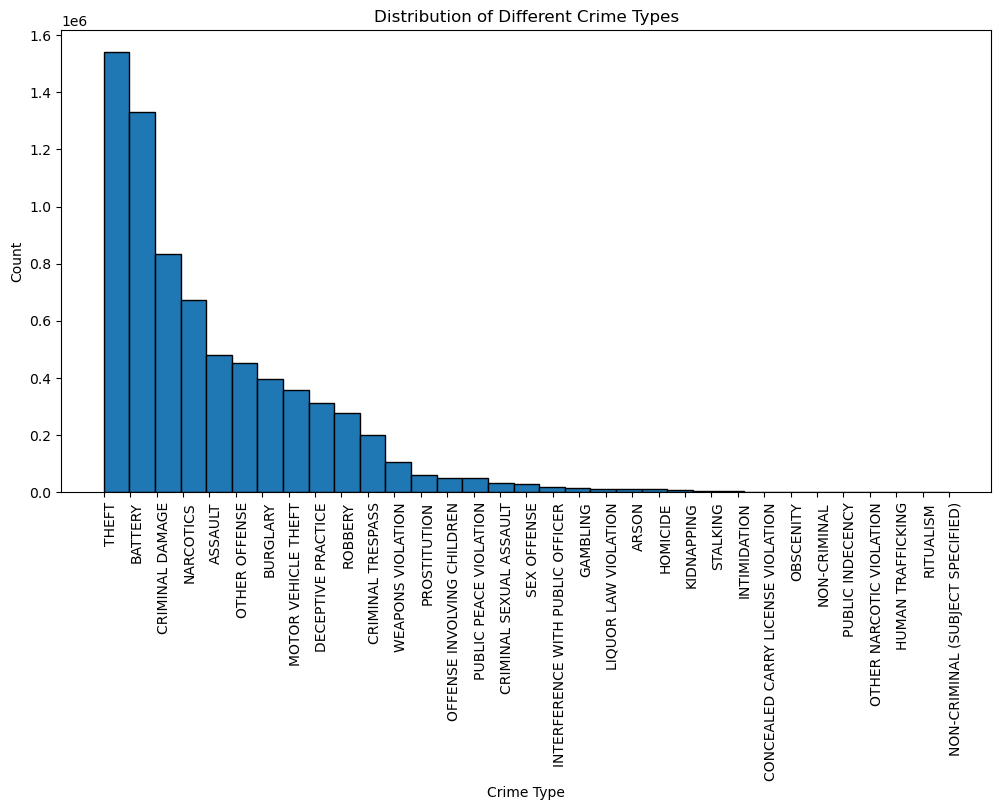

In [77]:
crime_type_counts = chicago_crime_clean['Primary Type'].value_counts()
crime_type_counts_sorted = crime_type_counts.sort_values(ascending = False)
sorted_data = chicago_crime_clean['Primary Type'].map(lambda x: crime_type_counts_sorted.index.get_loc(x))
# Create a histogram
plt.figure(figsize=(12,6))
plt.hist(sorted_data, bins=len(crime_type_counts_sorted), edgecolor='black')
plt.title('Distribution of Different Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='left', ticks=range(len(crime_type_counts_sorted.index)), labels=crime_type_counts_sorted.index)
plt.show()

The histogram is the distribution of crime types' counts, some types having fewer quantities, but I cannot give up any crime types' data since I am going to analyze how crime types influence arrest rates, also these incidents will keep happening in our lives even though the amount that occurs is small. The graph gives us information that the number of crime types of theft and battery is the highest.

In [78]:
crime_arrest.set_index('Primary Type', inplace = True)
print(crime_arrest.loc[crime_arrest['Percent_Arrested (True)'].idxmax()])
print(crime_arrest.loc[crime_arrest['Percent_Arrested (True)'].idxmin()])
print(crime_arrest.describe())

Arrested (False)             277.000000
Arrested (True)            61181.000000
Percent_Arrested (True)       99.549286
Name: PROSTITUTION, dtype: float64
Arrested (False)           373154.000000
Arrested (True)             22361.000000
Percent_Arrested (True)         5.653641
Name: BURGLARY, dtype: float64
       Arrested (False)  Arrested (True)  Percent_Arrested (True)
count      3.300000e+01        33.000000                33.000000
mean       1.640142e+05     56231.030303                41.441135
std        3.246437e+05    125913.303927                36.313729
min        3.000000e+00         2.000000                 5.653641
25%        1.670000e+02       623.000000                11.912738
50%        6.564000e+03     12790.000000                20.752443
75%        2.508970e+05     54229.000000                72.812999
max        1.374957e+06    668226.000000                99.549286


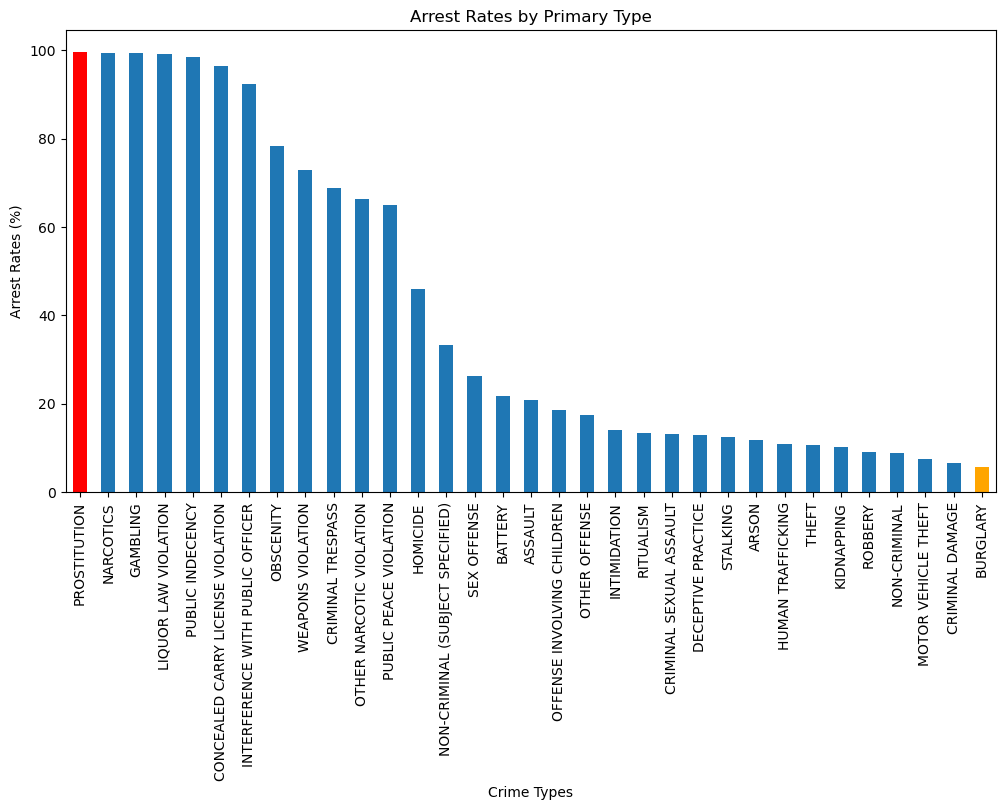

In [79]:
crime_arrest_sorted = crime_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)

ax = crime_arrest_sorted.plot(kind='bar', y='Percent_Arrested (True)', legend=False, figsize=(12, 6))
max_index = crime_arrest_sorted['Percent_Arrested (True)'].idxmax()
min_index = crime_arrest_sorted['Percent_Arrested (True)'].idxmin()
ax.patches[crime_arrest_sorted.index.get_loc(max_index)].set_facecolor('red')
ax.patches[crime_arrest_sorted.index.get_loc(min_index)].set_facecolor('orange')

plt.title('Arrest Rates by Primary Type')
plt.xlabel('Crime Types')
plt.ylabel('Arrest Rates (%)')
plt.xticks(rotation=90)
plt.show()

Now, we can easily see that the crime type of prostitution has the highest arrest rate at about 99.6%, while the type of burglary has the lowest arrest rate at about 5.7%. This bar chart with each crime type on the x-axis and arrest rates on the y-axis, shows that most of the crime types have either high arrest rates greater than 60% or low arrest rates less than 20%. According to the distribution of crime types before, we found that 'theft' and 'battery' are the most frequent occurrences but their arrest rates are not the highest, which describes from the side that it is very difficult to catch this type of criminal. Again, it expresses crime types will influence arrest rates to a certain degree.

### $X_2$: Community Areas of Chicago

In this part, we will focus on how community areas will influence arrest rates without other factors.

In [37]:
# Create a pivot table to count the number of 'True' and 'False' in each community area
area_arrest = chicago_crime_clean.pivot_table(index='Community Area', columns='Arrest', aggfunc='size', fill_value=0)
area_arrest.columns = ['Arrested (False)', 'Arrested (True)']
area_arrest['Percent_Arrested (True)'] = (area_arrest['Arrested (True)'] / (area_arrest['Arrested (False)'] + 
                                                                              area_arrest['Arrested (True)'])) * 100
area_arrest_sorted = area_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)
area_arrest = area_arrest.reset_index()

In [81]:
area_arrest.describe()

,Community Area,Arrested (False),Arrested (True),Percent_Arrested (True)
count,77.000000,77.000000,77.000000,77.000000
mean,39.000000,70291.792208,24099.012987,22.534966
std,22.371857,54214.181844,25795.026325,6.608262
min,1.000000,6387.000000,823.000000,10.383647
25%,20.000000,28961.000000,6857.000000,17.701992
50%,39.000000,53404.000000,14875.000000,22.382251
75%,58.000000,99376.000000,33282.000000,25.630492
max,77.000000,284329.000000,168020.000000,42.966774


In [38]:
area_arrest.set_index('Community Area', inplace = True)
print(area_arrest.loc[area_arrest['Percent_Arrested (True)'].idxmax()])
print(area_arrest.loc[area_arrest['Percent_Arrested (True)'].idxmin()])

Arrested (False)           77811.000000
Arrested (True)            58620.000000
Percent_Arrested (True)       42.966774
Name: 26, dtype: float64
Arrested (False)           12100.000000
Arrested (True)             1402.000000
Percent_Arrested (True)       10.383647
Name: 12, dtype: float64


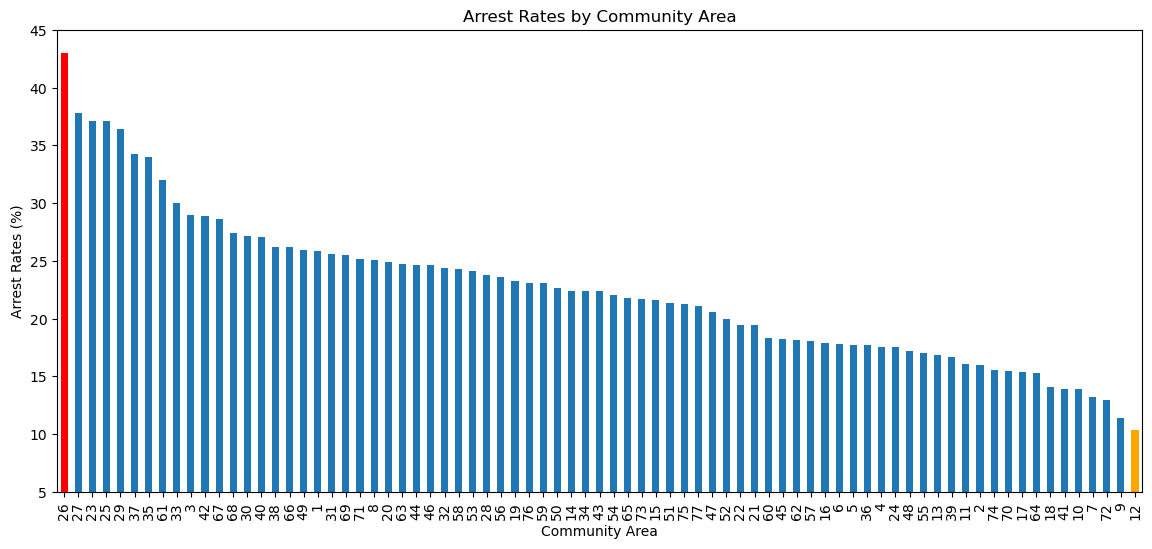

In [83]:
ax2 = area_arrest_sorted.plot(kind='bar', y='Percent_Arrested (True)', legend=False, figsize=(14, 6))
max_index2 = area_arrest_sorted['Percent_Arrested (True)'].idxmax()
min_index2 = area_arrest_sorted['Percent_Arrested (True)'].idxmin()
ax2.patches[area_arrest_sorted.index.get_loc(max_index2)].set_facecolor('red')
ax2.patches[area_arrest_sorted.index.get_loc(min_index2)].set_facecolor('orange')
plt.ylim(5,45)
plt.title('Arrest Rates by Community Area')
plt.xlabel('Community Area')
plt.ylabel('Arrest Rates (%)')
plt.show()

The bar plot above shows each community area with respect to arrest rates. Through observation, we can see that Area 12 has the lowest arrest rate at 10.4%, and Area 26 has the highest arrest rate at 43%. In addition, from the table above, the average arrest rate is about 22.5%, which is less than the arrest rates we have seen before based on the type of crime. We are interested in the root causes of the different arrest rates in different regions, so we might merge another dataset in future projects, like different regional economies.

### $X_3$: Year

In this section, we are going to study changes in arrest rates from year to year.

In [282]:
# Create a pivot table to count the number of 'True' and 'False' in each year
year_arrest = chicago_crime_clean.pivot_table(index='Year', columns='Arrest', aggfunc='size', fill_value=0)
year_arrest.columns = ['Arrested (False)', 'Arrested (True)']
year_arrest['Percent_Arrested (True)'] = (year_arrest['Arrested (True)'] / (year_arrest['Arrested (False)'] + 
                                                                              year_arrest['Arrested (True)'])) * 100
year_arrest_sorted = year_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)
year_arrest = year_arrest.reset_index()

In [85]:
year_arrest.describe()

,Year,Arrested (False),Arrested (True),Percent_Arrested (True)
count,22.000000,22.000000,22.000000,22.000000
mean,2012.500000,246021.272727,84346.545455,24.214572
std,6.493587,50938.203752,39477.788173,6.452209
min,2002.000000,173138.000000,25025.000000,11.569934
25%,2007.250000,207865.000000,52870.750000,19.907587
50%,2012.500000,236506.000000,88518.000000,27.097991
75%,2017.750000,297128.750000,108642.250000,28.793249
max,2023.000000,331541.000000,144248.000000,31.170812


In [15]:
print(year_arrest.loc[year_arrest['Percent_Arrested (True)'].idxmax()])
print(year_arrest.loc[year_arrest['Percent_Arrested (True)'].idxmin()])

Year                         2005.000000
Arrested (False)           309646.000000
Arrested (True)            140230.000000
Percent_Arrested (True)        31.170812
Name: 3, dtype: float64
Year                         2022.000000
Arrested (False)           207166.000000
Arrested (True)             27105.000000
Percent_Arrested (True)        11.569934
Name: 20, dtype: float64


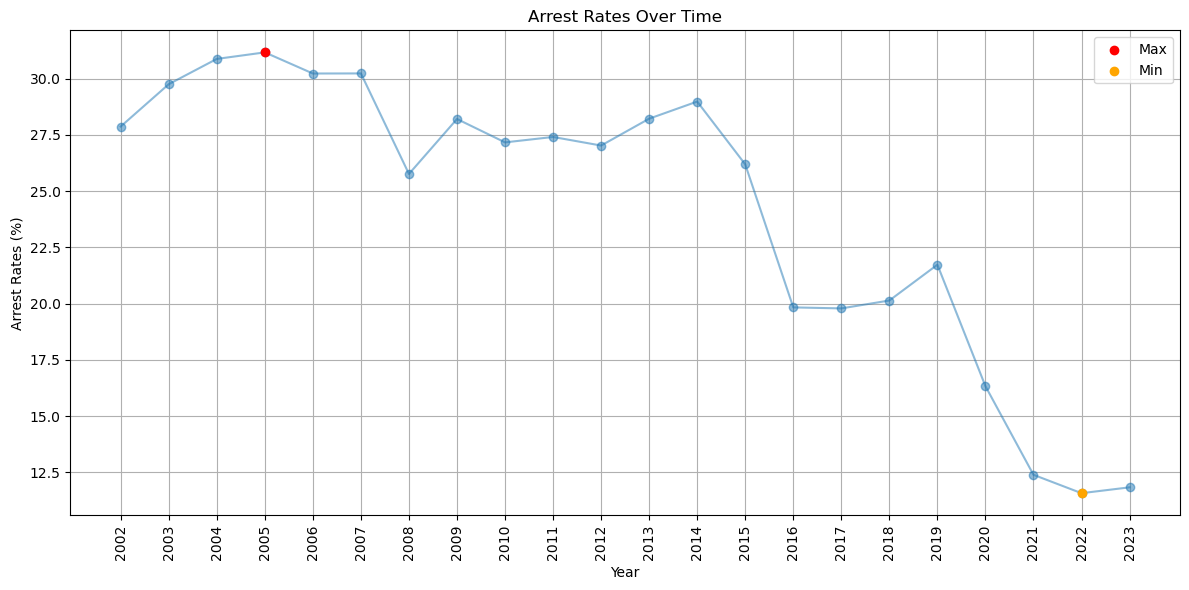

In [283]:
plt.figure(figsize=(12, 6))
plt.plot(year_arrest['Year'], year_arrest['Percent_Arrested (True)'], marker='o', linestyle='-', alpha=0.5, zorder=2)

max_index = year_arrest['Percent_Arrested (True)'].idxmax()
min_index = year_arrest['Percent_Arrested (True)'].idxmin()
plt.scatter(year_arrest['Year'][max_index], year_arrest['Percent_Arrested (True)'][max_index], 
            color='red', label='Max', zorder=3)
plt.scatter(year_arrest['Year'][min_index], year_arrest['Percent_Arrested (True)'][min_index], 
            color='orange', label='Min', zorder=3)

plt.title('Arrest Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Arrest Rates (%)')
plt.grid(True)
plt.xticks(year_arrest['Year'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

The line chart above illustrates the arrest rates from 2002 to 2023. The maximum arrest rate was in 2005, which is 31.2%, and the minimum arrest rate was in 2022 at 11.6%. Moreover, we could see that there is a corner in 2008, and we might guess that is due to the 2008 recession but need more evidence. There are two sharp declines, one was in 2014, and another was in 2019. We should do more research to explain the phenomenon. Also, the statistics summary mentions the average arrest rate is about 24.2%.

### Combine Independent Variables

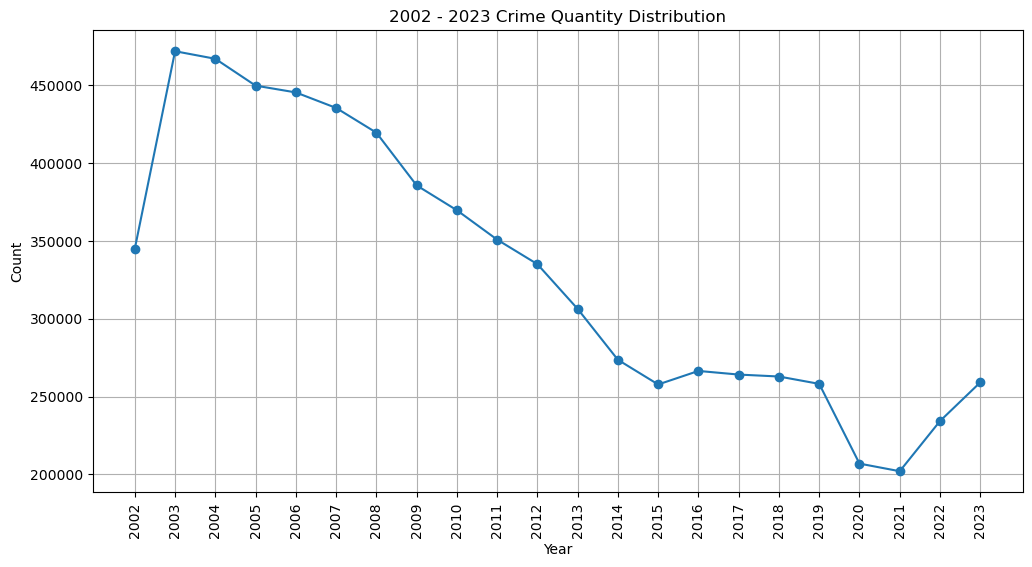

In [13]:
year_counts = chicago_crime_clean['Year'].value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-')
plt.title('2002 - 2023 Crime Quantity Distribution')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(year_counts.index, rotation=90)
plt.grid(True)
plt.show()

The line chart above shows the variation in crime quantity from 2002 to 2023. It gives us a surprising result since the number of crimes peaked in 2003 and then continued to decline, reaching its lowest in 2021. We can see that the quantity changes are quite different with the arrest rates changing over time, so we want to explore how each primary type and community area influences arrest rates in each year.

In [10]:
combine = chicago_crime_clean.groupby(['Community Area', 'Primary Type', 'Year']).size().reset_index(name='Count')
# Sort the DataFrame by Year and count
combine_sorted = combine.sort_values(by=['Year', 'Count'], ascending=[True, False])
# Set 'Year' as the index
new = combine_sorted.set_index('Year', inplace=True)
new = combine_sorted.groupby('Year')
print(new.get_group(2005).head())
print(new.get_group(2022).head())

      Community Area Primary Type  Count
Year                                    
2005              25    NARCOTICS   7295
2005              25      BATTERY   5828
2005               8        THEFT   4761
2005              32        THEFT   4479
2005              23    NARCOTICS   4097
      Community Area Primary Type  Count
Year                                    
2022               8        THEFT   4122
2022              32        THEFT   3324
2022              28        THEFT   3295
2022              24        THEFT   2602
2022              25      BATTERY   2378


The table above shows the quantity of the top five crime types in 2005 and 2022 since I want to verify whether crime types will influence arrest rates in community areas. Through observation, I found that the year 2022, which had the lowest arrest rate, had the highest number of thieves; and in 2005 with the highest arrest rate had the most counts of narcotics. Also, the results are totally different from what I found before using a single variable. Therefore, I would guess that the combination of crime types and community areas will influence the arrest rate over time.

In [14]:
most_frequent_type_idx = combine.groupby('Community Area')['Count'].idxmax()
# Create a DataFrame with the most frequent 'Primary Type' for each 'Community Area'
most_frequent_types = combine.loc[most_frequent_type_idx][['Community Area', 'Primary Type', 'Count']]
# Count the number of areas where each crime type occurs the most
area_counts = most_frequent_types.groupby('Primary Type').size().reset_index(name='Area Count')
print(area_counts)

worst_frequent_type_idx = combine.groupby('Community Area')['Count'].idxmin()
# Create a DataFrame with the worst frequent 'Primary Type' for each 'Community Area'
worst_frequent_types = combine.loc[worst_frequent_type_idx][['Community Area', 'Primary Type', 'Count']]
# Count the number of areas where each crime type occurs the worst
area_counts2 = worst_frequent_types.groupby('Primary Type').size().reset_index(name='Area Count')
print(area_counts2)

        Primary Type  Area Count
0            BATTERY          23
1    CRIMINAL DAMAGE           7
2  CRIMINAL TRESPASS           1
3          NARCOTICS           7
4              THEFT          39
                        Primary Type  Area Count
0                              ARSON          51
1  CONCEALED CARRY LICENSE VIOLATION          23
2                           GAMBLING           2
3                           HOMICIDE           1


Here, it represents 5 types of crime that occur the most in each area of Chicago and 4 types of crime that occur the least from 2002 to 2023. We know that in 77 community areas, theft is the most common crime in these areas, which happened the most frequently in 39 areas. Battery is the second-highest crime type in 23 out of 77 areas. On the contrary, there are 51 areas where arson occurs the least in all of the crime types.

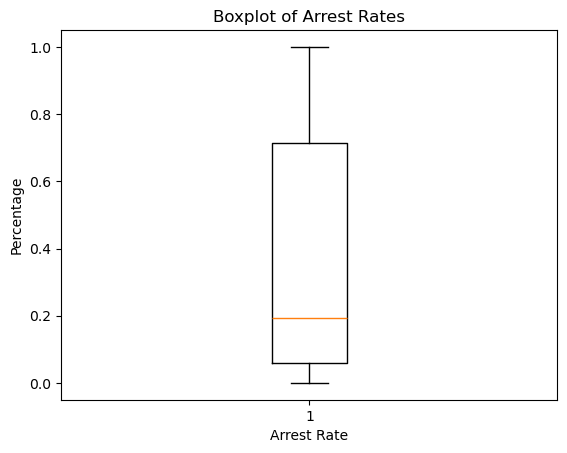

,Arrest
,mean
count,40268.000000
mean,0.364232
std,0.374328
min,0.000000
25%,0.059829
50%,0.193025
75%,0.714286
max,1.000000


In [20]:
new = chicago_crime_clean.groupby(['Community Area', 'Primary Type', 'Year']).agg({'Arrest':['mean']})

# Create a boxplot for arrest rates
plt.boxplot(new)
plt.title('Boxplot of Arrest Rates')
plt.xlabel('Arrest Rate')
plt.ylabel('Percentage')
plt.show()
new.describe()

The boxplot of arrest rates represents the arrest rates based on 33 crime types and 77 community areas. We can see that its min is 0% and max is 100%, but the median rate is only around 19.3% and is a right-skewed plot. According to the box plot, the 25th percentile of the arrest rate is around 6% and the 75th percentile is around 71.4%, which is a huge difference.

# Project 2

## 2.1 The Message

This project aims to answer how different criminal types influence arrest rates. From Project 1, we notice that from 2002 to 2023, the number of crimes is on the decline overall, while there are several inflection points in the arrest rates. Also, from our initial visualization we see prostitution has the highest arrest rates, while burglary is the opposite; both are non-violent crime types. To gain a better understanding, we will create figures that show how arrest rates of criminal types change over time, and what is the difference between violent crimes and non-violent crimes.

In [9]:
primary_types = chicago_crime_clean['Primary Type'].unique()
primary_types

array(['THEFT', 'BATTERY', 'ASSAULT', 'WEAPONS VIOLATION',
       'OTHER OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER', 'BURGLARY',
       'NARCOTICS', 'MOTOR VEHICLE THEFT', 'CRIMINAL DAMAGE',
       'DECEPTIVE PRACTICE', 'OFFENSE INVOLVING CHILDREN',
       'CRIMINAL TRESPASS', 'ROBBERY', 'SEX OFFENSE',
       'PUBLIC PEACE VIOLATION', 'CRIMINAL SEXUAL ASSAULT',
       'PROSTITUTION', 'STALKING', 'HOMICIDE', 'KIDNAPPING', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION', 'GAMBLING',
       'LIQUOR LAW VIOLATION', 'INTIMIDATION', 'OBSCENITY',
       'PUBLIC INDECENCY', 'NON-CRIMINAL', 'HUMAN TRAFFICKING',
       'OTHER NARCOTIC VIOLATION', 'RITUALISM',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

In [284]:
violent_crimes = ['ASSAULT', 'WEAPONS VIOLATION', 'HOMICIDE', 'SEX OFFENSE', 'ROBBERY', 
                  'CRIMINAL SEXUAL ASSAULT', 'KIDNAPPING']

# Categorize primary types into violent and non-violent crimes
violent_types = [pt for pt in primary_types if pt in violent_crimes]
non_violent_types = [pt for pt in primary_types if pt not in violent_crimes]

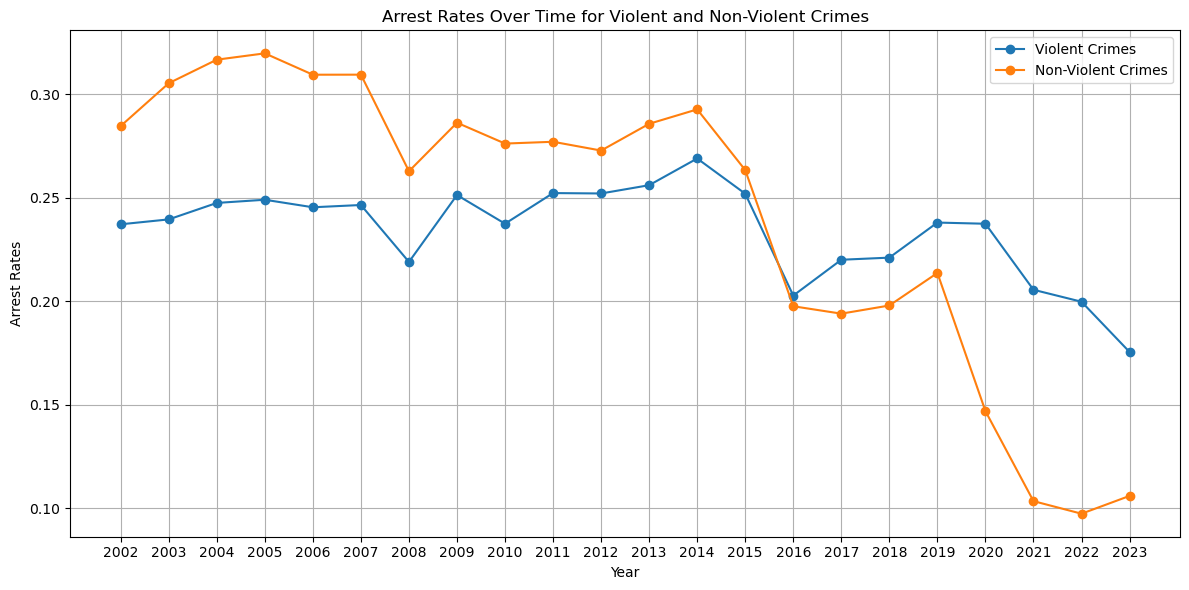

In [17]:
violent_data = chicago_crime_clean[chicago_crime_clean['Primary Type'].isin(violent_types)]
non_violent_data = chicago_crime_clean[chicago_crime_clean['Primary Type'].isin(non_violent_types)]

violent_arrest_rates = violent_data.groupby('Year')['Arrest'].mean()
non_violent_arrest_rates = non_violent_data.groupby('Year')['Arrest'].mean()

plt.figure(figsize=(12, 6))
plt.plot(violent_arrest_rates.index, violent_arrest_rates.values, marker='o', label='Violent Crimes')
plt.plot(non_violent_arrest_rates.index, non_violent_arrest_rates.values, marker='o', label='Non-Violent Crimes')

plt.xlabel('Year')
plt.ylabel('Arrest Rates')
plt.title('Arrest Rates Over Time for Violent and Non-Violent Crimes')
plt.legend()
plt.xticks(year_counts.index)
plt.grid(True)
plt.tight_layout()
plt.show()

I separate 33 primary types into two groups, violent and non-violent; and then show their corresponding arrest rates over time. The line chart presents that the arrest rates for violent crimes do not much change, ranging from 20% to 25%; but the arrest rates for non-violent crimes have a big difference, there was a sudden decline in 2019. Moreover, both of them had a local minimum in 2008; now we know that previously we found the lowest arrest rate in 2022 mainly due to the low arrest rate for nonviolent crimes during that year, and the highest arrest rate in 2005 was also due to the high arrest rate for nonviolent crimes. I will show more specifics about how each primary type changes in the next graph.

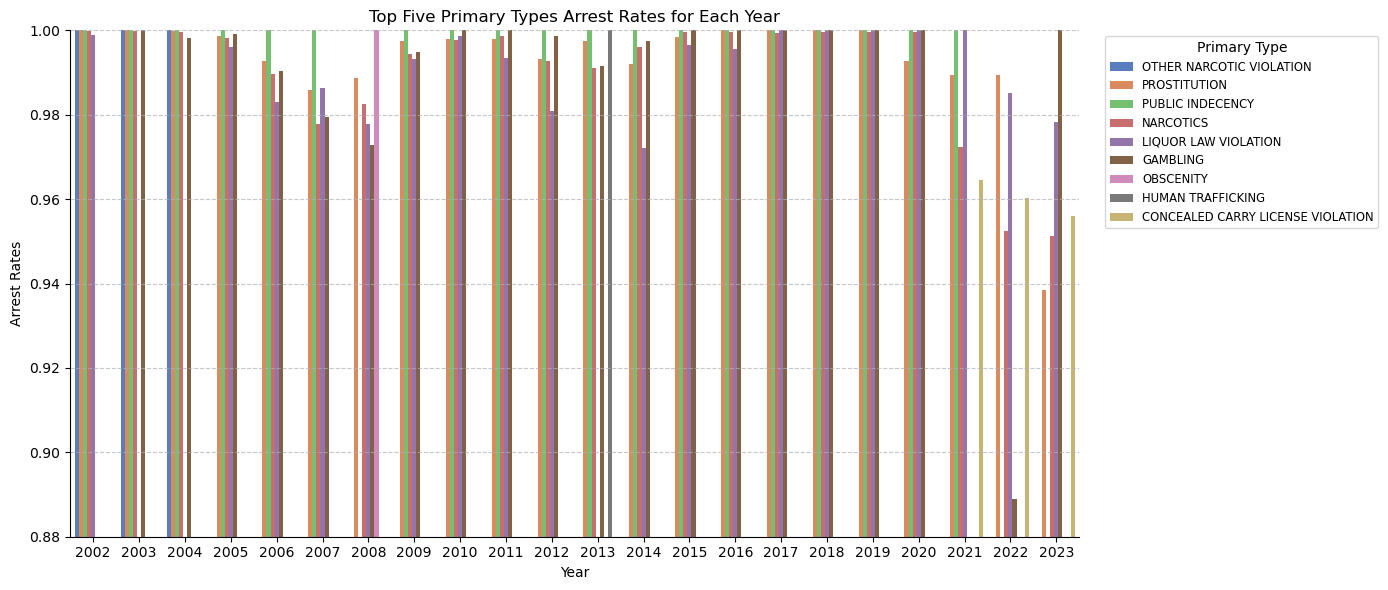

In [24]:
primary_time = chicago_crime_clean.groupby(['Year', 'Primary Type'])['Arrest'].mean().reset_index()
top_five_primary_types = primary_time.groupby('Year').apply(lambda x: x.nlargest(5, 'Arrest')).reset_index(drop=True)

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=top_five_primary_types, x='Year', y='Arrest', hue='Primary Type', palette='muted')

plt.xlabel('Year')
plt.ylabel('Arrest Rates')
plt.title('Top Five Primary Types Arrest Rates for Each Year')
plt.legend(title='Primary Type', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
plt.ylim(0.88,1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

The graph of the top five primary types arrest rates for each year shows the type of crime with the highest five arrest rates in every year from 2002 to 2023. There are a total of 33 types of crime, but we only select the top five and display them on the graph. This data suggests that other narcotic violation only had high arrest rates from 2002 to 2004, while prostitution and narcotics appear every year. In the rest types, public indecency, liquor law violation, and gambling have higher arrest rates in most of the years. There are several primary types that have unique data, concealed carry license violation only appear since 2021, obscenity only found in 2008, and human trafficking only in 2013; the latter two are the highest arrest rates in their respective years. It seems to show that once a crowd activity is detected and caught, the arrest rate is high. We are now looking at the whole Chicago area's arrest rates of primary types. Further research is needed to identify what factors influence the number of crimes in different community areas thereby further influencing arrest rates.

## 2.2 Maps and Interpretations

### Merging with a New Dataset

The new dataset I have chosen is per capita income in Chicago starting from 2006 to 2022 and divided into four periods, which is from the American Community Survey and collected by the Chicago Health Atlas, and this dataset is statistically classified by community name. It provides a crucial socio-economic dimension to my analysis of crime trends in Chicago. By merging this new dataset, I can observe how per capita income levels have evolved and potentially impacted various aspects of community life, including crime rates and law enforcement responses so that research how fluctuations in per capita income may intersect with crime trends across Chicago's diverse communities and then affect arrest rates. I call this new dataset 'per_capita_income', and I will also clean this data by dropping missing values. In the end, I am going to combine the new dataset into 'chicago_crime_clean' based on community area and call it 'merge'.

In [217]:
relative_path2 = os.path.join('..', 'Data', 'per_capita_income.csv')
abs_path2 = os.path.abspath(relative_path2)

# Read the CSV file
per_capita_income = pd.read_csv(abs_path2)

In [218]:
per_capita_income.isnull().any(axis=0)

Layer             True
Name              True
GEOID             True
Longitude         True
Latitude          True
PCI_2018-2022    False
PCI_2014-2018    False
PCI_2010-2014    False
PCI_2006-2010    False
dtype: bool

In [221]:
per_capita_income.dtypes

Layer             object
Name              object
GEOID            float64
Longitude        float64
Latitude         float64
PCI_2018-2022     object
PCI_2014-2018     object
PCI_2010-2014     object
PCI_2006-2010     object
dtype: object

In [222]:
per_capita_income = per_capita_income.dropna()
per_capita_income = per_capita_income.drop(['Longitude','Latitude','Layer'],axis=1)
per_capita_income['GEOID'] = per_capita_income['GEOID'].astype(int)
per_capita_income['PCI_2006-2010'] = per_capita_income['PCI_2006-2010'].astype(float)
per_capita_income['PCI_2010-2014'] = per_capita_income['PCI_2010-2014'].astype(float)
per_capita_income['PCI_2014-2018'] = per_capita_income['PCI_2014-2018'].astype(float)
per_capita_income['PCI_2018-2022'] = per_capita_income['PCI_2018-2022'].astype(float)

In [173]:
merge = pd.merge(chicago_crime_clean, per_capita_income, left_on='Community Area', right_on='GEOID', how='left')

In [174]:
merge = merge.drop(['GEOID','Description','District'],axis=1)

In [280]:
print(merge.head())

         ID Case Number Primary Type  Arrest  Community Area  Year   Latitude  \
0  12045583    JD226426        THEFT   False              35  2020  41.830482   
1  12031001    JD209965      BATTERY    True              60  2020  41.836310   
2  12093529    JD282112      ASSAULT    True              46  2020  41.747610   
3  12178140    JD381597      BATTERY   False              67  2020  41.774878   
4   4144897    HL474854      BATTERY   False              68  2005  41.781003   

   Longitude                            Location            Name  \
0 -87.621752  POINT (-87.621751752 41.830481843)         Douglas   
1 -87.639624  POINT (-87.639624112 41.836310224)      Bridgeport   
2 -87.549179  POINT (-87.549179329 41.747609555)   South Chicago   
3 -87.671375   POINT (-87.671374872 41.77487752)  West Englewood   
4 -87.652107  POINT (-87.652107119 41.781002663)       Englewood   

   PCI_2018-2022  PCI_2014-2018  PCI_2010-2014  PCI_2006-2010  
0    32629.90428    29563.06339    26820

### Maps

In [175]:
merge['Location'] = list(zip(merge.Longitude, merge.Latitude))
merge['Location'] = merge['Location'].apply(Point)

In [81]:
shapefile_path = os.path.join('..', 'Data', 'Boundaries - Community Areas (current).zip')
chicago_shape = gpd.read_file(shapefile_path)

In [228]:
chicago_shape['area_numbe'] = chicago_shape['area_numbe'].astype('int32')
merged_df = chicago_shape.merge(area_arrest, left_on="area_numbe", right_on='Community Area')

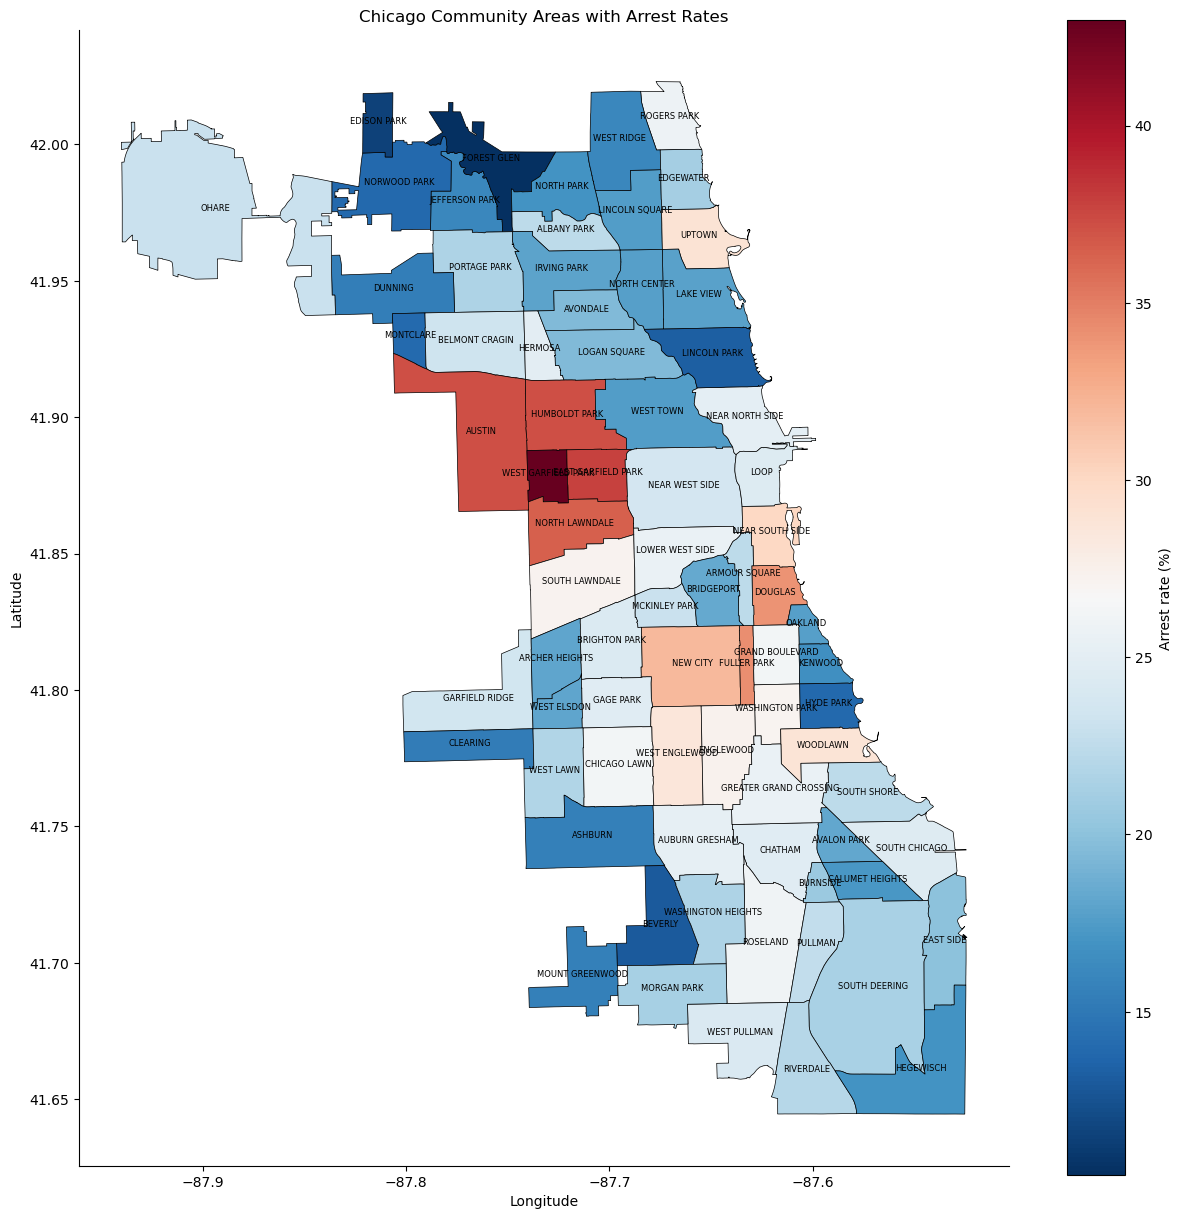

In [232]:
fig, gax = plt.subplots(figsize=(15, 15))

merged_df.plot(ax=gax, column='Percent_Arrested (True)', cmap='RdBu_r', legend=True,
               legend_kwds={'label': 'Arrest rate (%)'}, edgecolor='black', linewidth=0.5)

for idx, row in merged_df.iterrows():
    gax.annotate(text=str(row['community']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=6)
plt.title('Chicago Community Areas with Arrest Rates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

The map above shows the arrest rates in 77 community areas in Chicago. As we can see, West Garfield Park (area 26) has the highest arrest rate, and Forest Glen (area 12) has the lowest arrest rate. It is worth noting that a couple of areas around West Garfield Park also have high arrest rates. Also, most of the north side of Chicago have lower arrest rates. The map as a whole is in light blue, the same as when we analyzed the relationship between community areas and arrest rates separately, the average is around 22.5%. Later, I will create a map that present relationship between crime quantity with community areas.

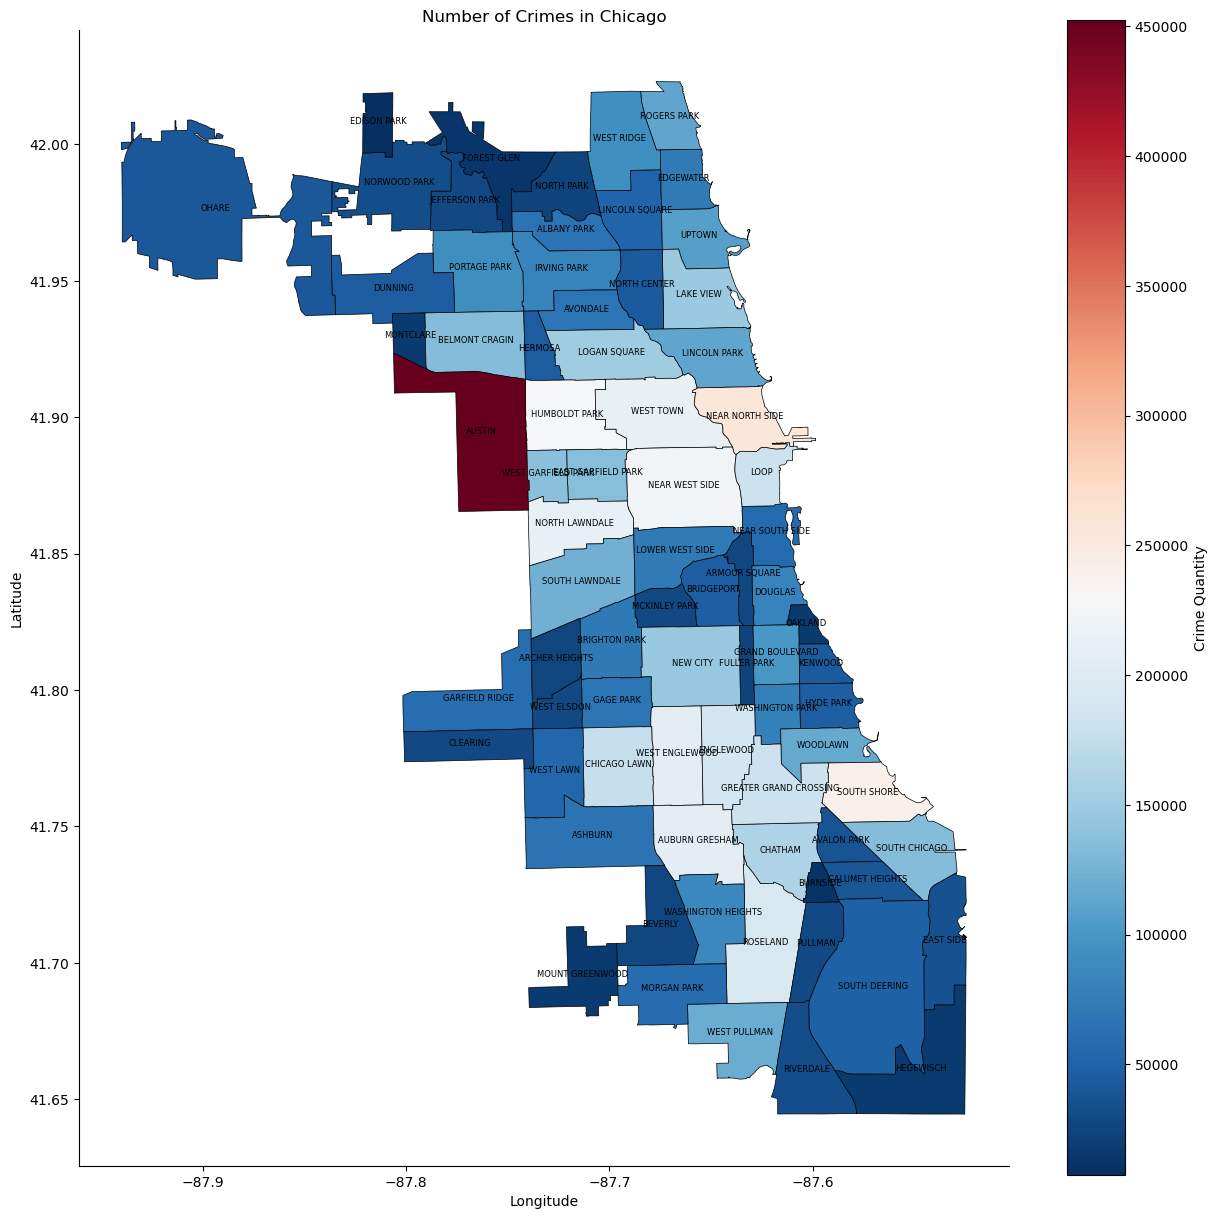

In [233]:
crime_area_counts = chicago_crime_clean['Community Area'].value_counts()
merged_df2 = chicago_shape.merge(crime_area_counts, left_on="area_numbe", right_on='Community Area')
fig, gax = plt.subplots(figsize=(15, 15))

merged_df2.plot(ax=gax, column='count', cmap='RdBu_r', legend=True,
               legend_kwds={'label': 'Crime Quantity'}, edgecolor='black', linewidth=0.5)

for idx, row in merged_df2.iterrows():
    gax.annotate(text=str(row['community']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=6)
plt.title('Number of Crimes in Chicago')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

There is an area that sticks out, which is Austin (area 25), it has the largest number of crimes compared to other areas. Combined with the previous map, we found that there is a correlation between the number of crimes and the arrest rate. However, some areas that have lower crime quantities have decent arrest rates, like a couple of areas on the south side of Chicago; but the opposite is true in several areas on Chicago's north side, where the number of crimes is low and the arrest rate is low. Especially, Near North Side (area 8) has a higher crime count, but its arrest rate is not so high. Since I discussed violent and non-violent crimes have a large difference in arrest rates before, one guess for this situation is that the number of these two types of occurrence is distributed differently in different areas. Also, I will create a map to show how frequently prostitution incident occurs across Chicago, the type which has the highest arrest rate I analyzed before.

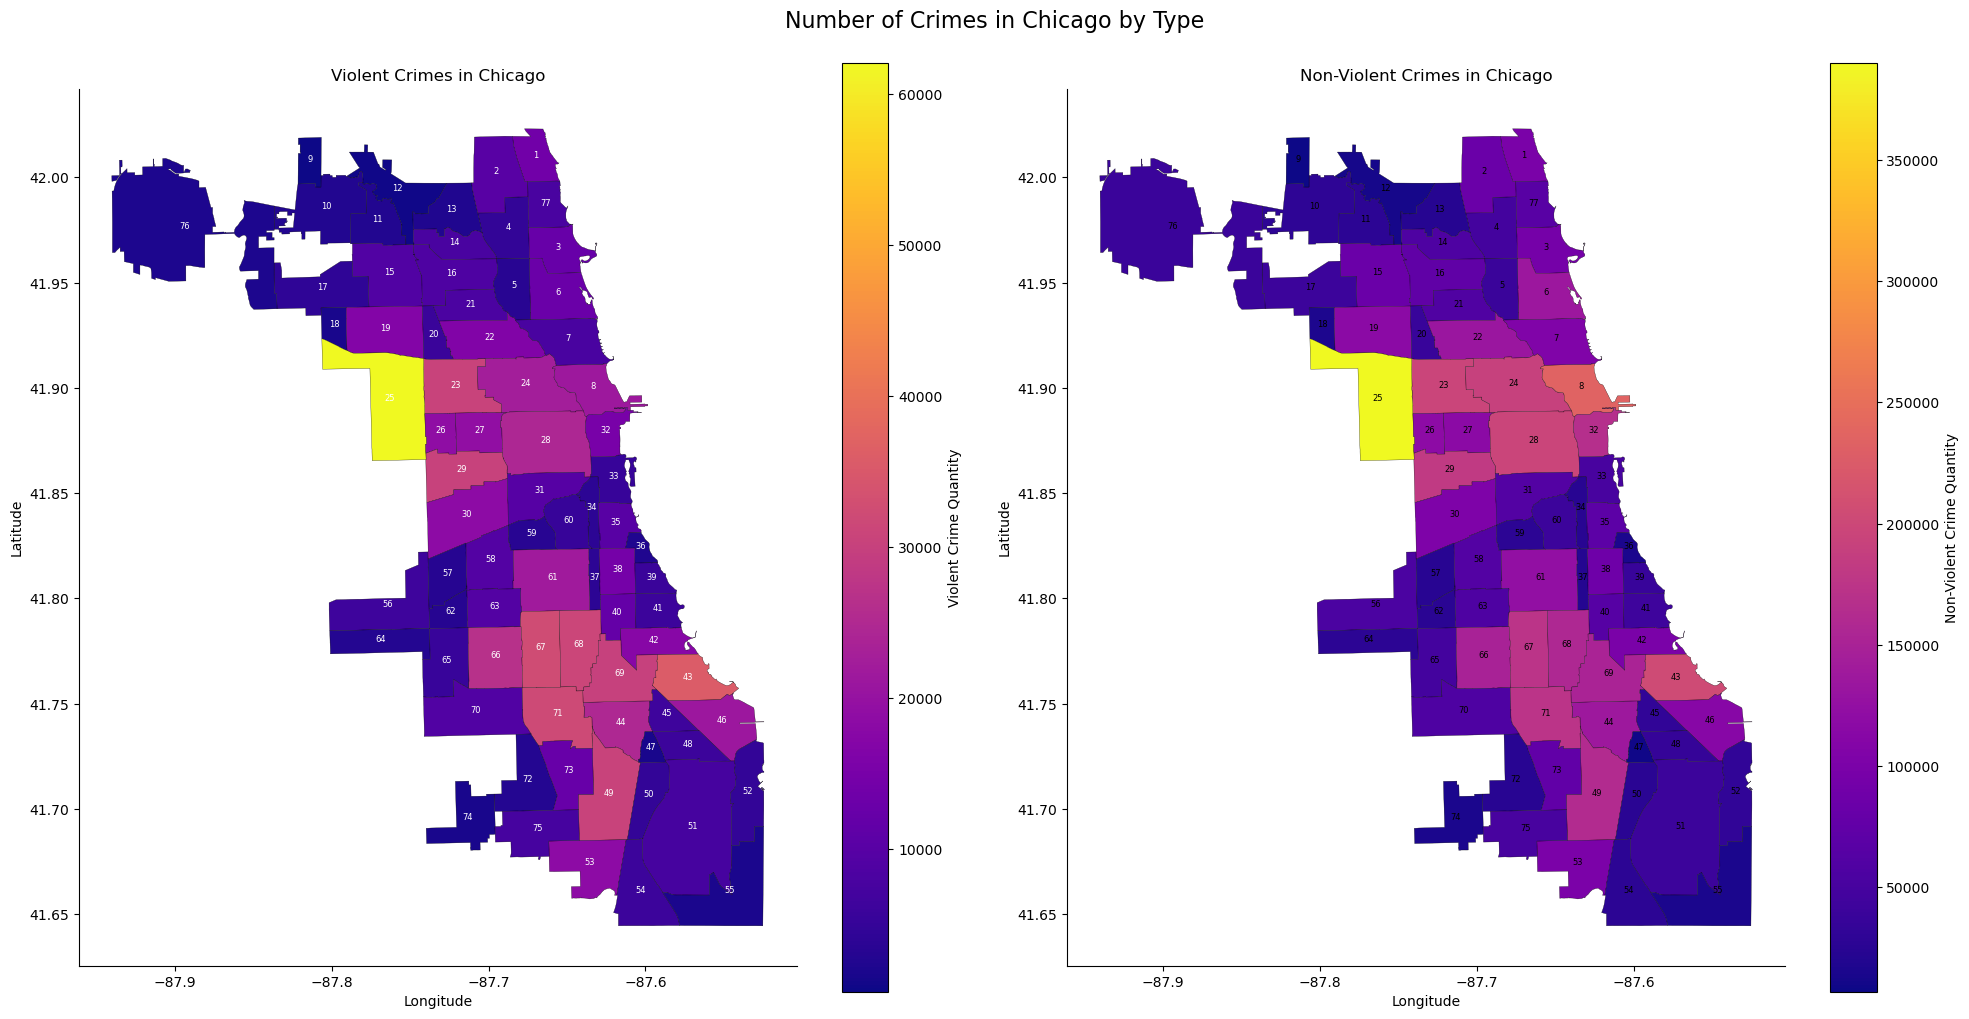

In [211]:
violent_data_counts = violent_data['Community Area'].value_counts()
non_violent_data_counts = non_violent_data['Community Area'].value_counts()
merged_df3 = chicago_shape.merge(violent_data_counts, left_on="area_numbe", right_on='Community Area')
merged_df4 = chicago_shape.merge(non_violent_data_counts, left_on="area_numbe", right_on='Community Area')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
merged_df3.plot(ax=axes[0], column='count', cmap='plasma', legend=True, legend_kwds={'label': 'Violent Crime Quantity'},
               edgecolor='black', linewidth=0.2)
axes[0].set_title('Violent Crimes in Chicago')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
for idx, row in merged_df3.iterrows():
    axes[0].annotate(text=row['area_numbe'], color='white',xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center', fontsize=6)

merged_df4.plot(ax=axes[1], column='count', cmap='plasma', legend=True, legend_kwds={'label': 'Non-Violent Crime Quantity'},
               edgecolor='black', linewidth=0.2)
axes[1].set_title('Non-Violent Crimes in Chicago')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
for idx, row in merged_df4.iterrows():
    axes[1].annotate(text=row['area_numbe'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center', fontsize=6)

plt.suptitle('Number of Crimes in Chicago by Type', fontsize=16, x=0.5, y=1)
plt.tight_layout()
plt.show()

Now, it is clear to see how violent and non-violent crimes are distributed in each community area. To keep the map clean and not messy, I use area numbers instead of area names on the graph. According to two maps, there is no doubt that Austin (area 25) has the highest quantity of both violent and non-violent crimes, but the number of non-violent crimes is much higher than violent crimes. Moreover, the distribution of the two types is roughly the same in 77 areas, but the non-violent crimes quantity are greater than violent crimes overall, so we might conclude that non-violent crime is the main factor affecting the arrest rate.

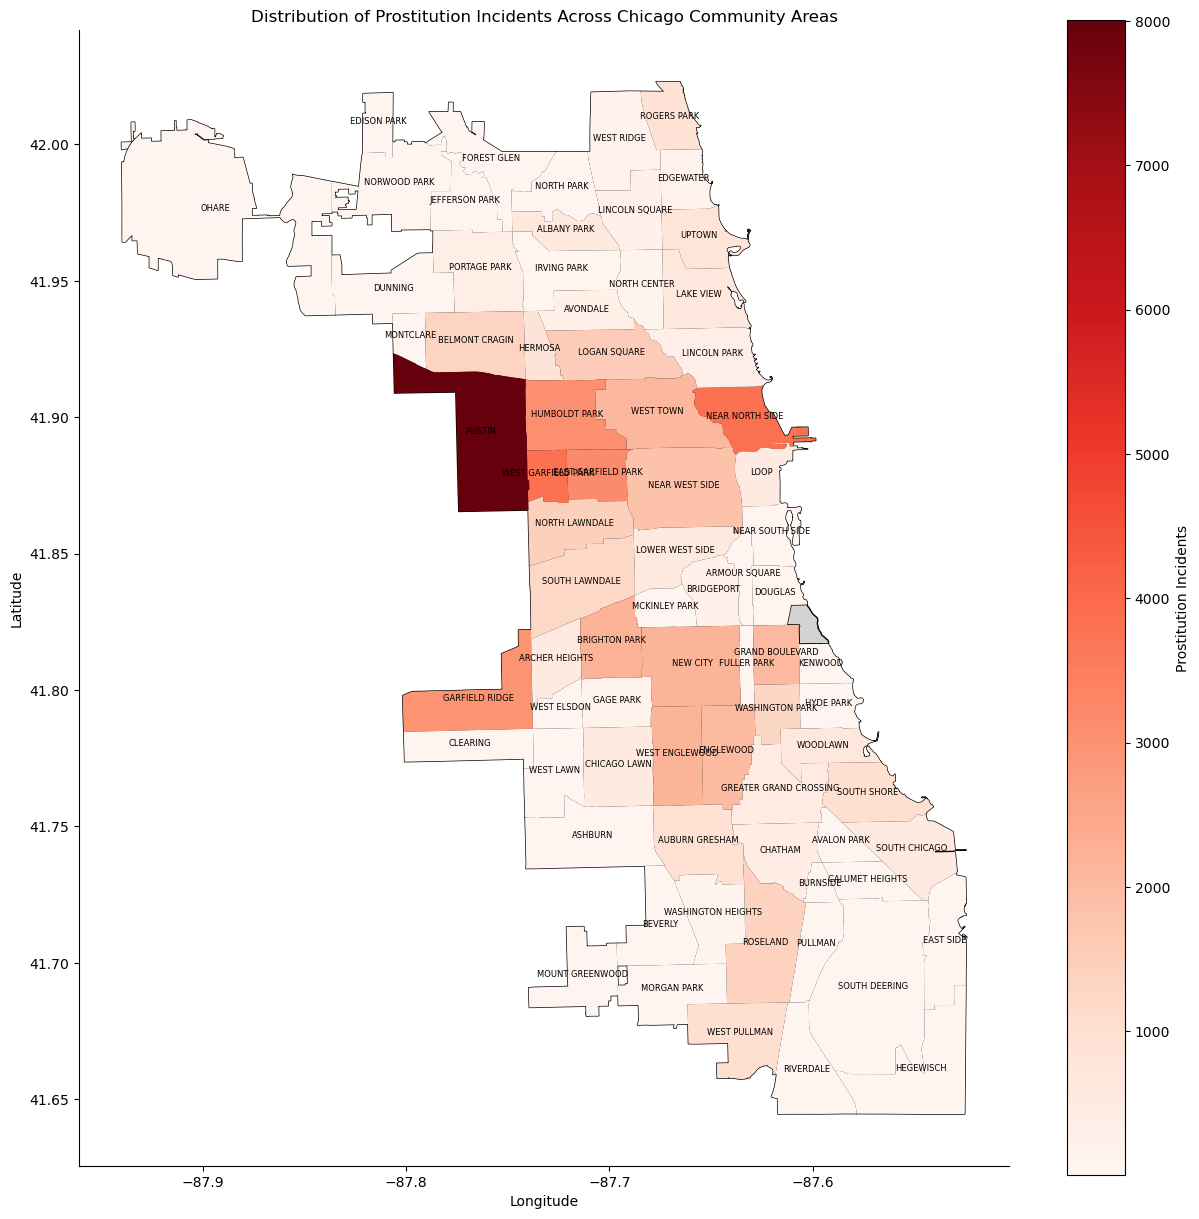

In [271]:
prostitution_data = chicago_crime_clean[chicago_crime_clean['Primary Type'] == 'PROSTITUTION']
prostitution_counts = prostitution_data.groupby(['Community Area']).size().reset_index(name='Incident Count')
merged_df9 = chicago_shape.merge(prostitution_counts, left_on="area_numbe", right_on='Community Area')

fig, ax = plt.subplots(figsize=(15, 15))
chicago_shape.plot(ax=ax, color='lightgrey', edgecolor='black')
merged_df9.plot(ax=ax, column='Incident Count', cmap='Reds', legend=True, legend_kwds={'label': 'Prostitution Incidents'})
for idx, row in merged_df9.iterrows():
    ax.annotate(text=str(row['community']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=6)

ax.set_title('Distribution of Prostitution Incidents Across Chicago Community Areas')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

From the map above we know that there is one area, Oakland (area 36) that does not have prostitution data. And not unexpectedly, Austin (area 25) has the most occurrences, which explains why this area has top-ranked arrest rates. Also, Humboldt Park (area 23), West Garfield Park (area 26), and East Garfield Park (area 27) both have higher arrest rates. Hence, it is similar to what we have seen before, the number of types of crime with the highest arrest rates affects local arrest rates to some extent. Remember I said earlier that the arrest rate in Near North Side (area 8) is not outstanding, it also has higher prostitution incidents, so I want to use the new dataset to see whether some reasons could explain this phenomenon.

In [191]:
merge_con1 = merge.groupby('Community Area')['PCI_2006-2010'].mean()
merge_con2 = merge.groupby('Community Area')['PCI_2010-2014'].mean()
merge_con3 = merge.groupby('Community Area')['PCI_2014-2018'].mean()
merge_con4 = merge.groupby('Community Area')['PCI_2018-2022'].mean()

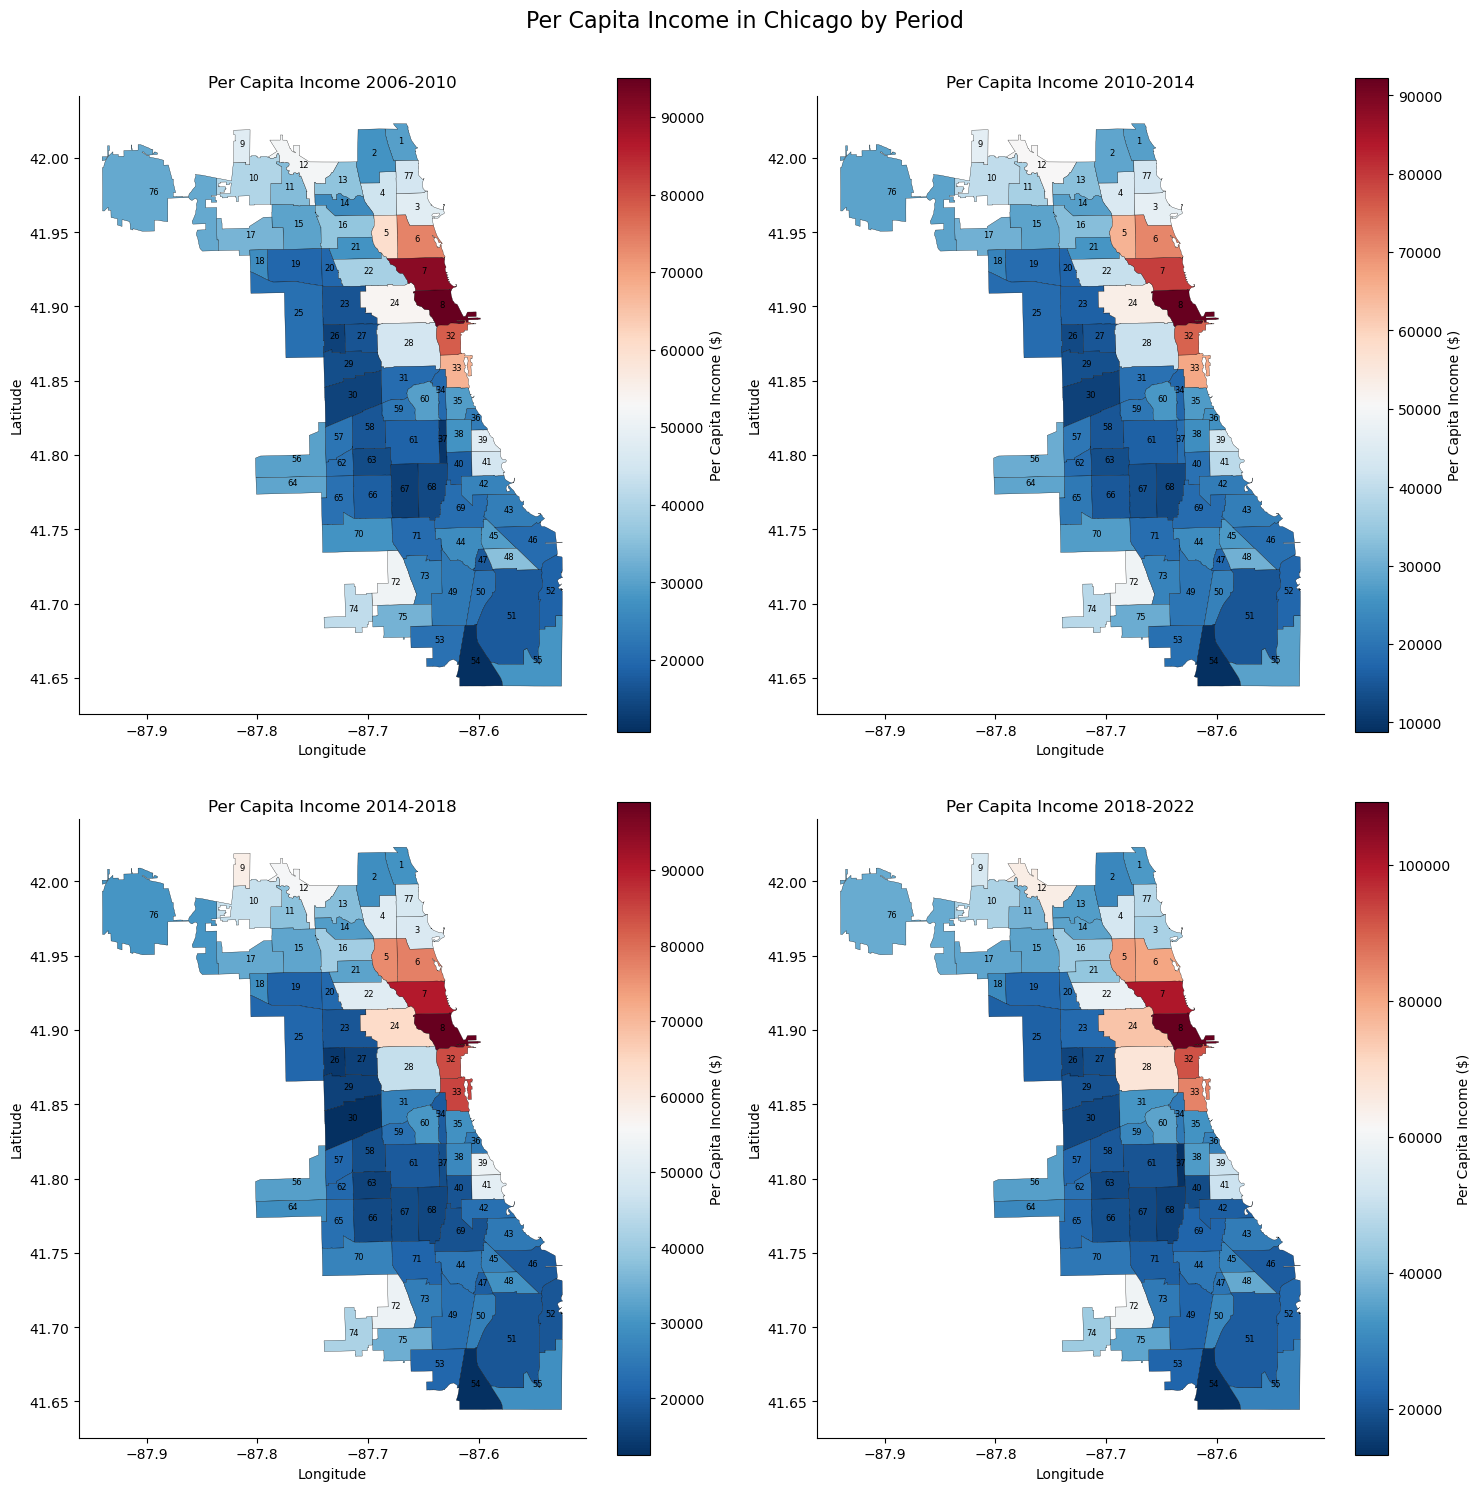

In [285]:
merged_df5 = chicago_shape.merge(merge_con1, left_on="area_numbe", right_on='Community Area')
merged_df6 = chicago_shape.merge(merge_con2, left_on="area_numbe", right_on='Community Area')
merged_df7 = chicago_shape.merge(merge_con3, left_on="area_numbe", right_on='Community Area')
merged_df8 = chicago_shape.merge(merge_con4, left_on="area_numbe", right_on='Community Area')

fig, gax = plt.subplots(2, 2, figsize=(15, 15))

merged_dfs = [merged_df5, merged_df6, merged_df7, merged_df8]
periods = ['2006-2010', '2010-2014', '2014-2018', '2018-2022']

for idx, merged_df in enumerate(merged_dfs):
    ax = gax[idx // 2, idx % 2]
    
    merged_df.plot(ax=ax, column=f'PCI_{periods[idx]}', cmap='RdBu_r', legend=True, 
                   legend_kwds={'label': 'Per Capita Income ($)'}, edgecolor='black', linewidth=0.2)
    
    ax.set_title(f'Per Capita Income {periods[idx]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for idx, row in merged_df.iterrows():
        ax.annotate(text=str(row['area_numbe']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    horizontalalignment='center', fontsize=6)

plt.suptitle('Per Capita Income in Chicago by Period', fontsize=16, x=0.5, y=1)
plt.tight_layout()
plt.show()

The map above contains four subgraphs, which present per capita income in Chicago from 2006 to 2022. As we can see, Near North Side (area 8) has the highest per capita income for all periods, and West Town (area 24) per capita income increases over time. This data might be used to explain why Near North Side (area 8) has a higher crime quantity but lower arrest rates, but I still need to find more information about it, like Police resources and race distribution. Overall, the per capita income of each community area in Chicago is increasing year by year, but the gap between rich and poor areas is still growing because some areas are growing faster and some less according to colour and number on the legend. If we divide Chicago into two groups, per capita income in the Northeast as a whole would be slightly higher than elsewhere. Combining the previous map of "Number of Crimes in Chicago", Near North Side (area 8) is also the second-highest area where crime incidents occur, but its arrest rate is only around 25% by the map of "Chicago Community Areas with Arrest Rates". In addition, it seems like areas with lower per capita incomes have higher rates of violent crime.

# Project 3

## 3.1 Potential Data to Scrape

To enhance the research on the influence of crime types on arrest rates in various areas of Chicago, acquiring data on criminal population demographics by community areas would provide valuable insights. By obtaining a criminal population survey, I can gather information on the demographic characteristics of individuals involved in criminal activities within specific neighbourhoods.

The Chicago Police website (https://publicsearch1.chicagopolice.org/Arrests) serves as a potential source for such data, offering a comprehensive list of crime types for adult arrest records. This dataset includes details such as the individual's name, current age, arrest date, and district of arrest.

By merging this new dataset with existing data on arrest rates, crime quantities, and per capita income in each community area, I can explore potential correlations between demographic factors and crime outcomes. For instance, analyzing whether certain types of crimes are more commonly committed by males or females could shed light on gender disparities in criminal behaviour and law enforcement outcomes. Additionally, investigating whether arrest rates vary based on demographic characteristics such as age or socioeconomic status can provide insights into disparities in policing practices across different community areas.

## 3.2 Potential Challenges

There are several challenges when scraping the website. 

1. The first challenge revolves around the frequency of data updates on the website. It is unclear whether the website updates its crime data daily, monthly, quarterly, or annually. This uncertainty necessitates regular checks over time to ensure that the data used for analysis is current and accurate.

2. Another challenge is the variability in crime types and their corresponding naming conventions on the website. The names of crimes listed may differ from those used in my research project, requiring meticulous identification and mapping of each crime type. Additionally, websites with multiple filters and dynamic content often have complex HTML structures, making it challenging to accurately locate and extract the required data. This complexity adds to the time and effort required for scraping, as each crime type must be individually identified and scraped to ensure comprehensive data collection.

3. Some crucial data, such as gender distribution or crime rates in specific districts need clicking on the "Details" button, leading to additional pages with relevant information. Navigating through these pages and extracting the desired data adds another layer of complexity to the web scraping process.

4. It looks like the website only records data before 2014, however, I want to research the years between 2002 to 2023. The lack of historical data beyond a certain point restricts the scope of my analysis and may introduce biases or gaps in the findings. Hence, it might not so perfect for me to use in this project.

After trying to scrape the website that I want to use, it is difficult beyond imagination. Firstly, I found that it does not show the community area, instead, it shows districts and beats, which are not the category I want. Also, there are a lot of pages of data, which means I am going to have to click on a page again and scrape them.

Overall, the complexity of navigating web scraping, coupled with the inherent limitations of available data sets, presents huge challenges in obtaining the information necessary to effectively achieve research objectives.

## 3.3 Scraping Data from a Website

In this part, I will scrape the average temperature from 2010 to 2019 of Chicago from the Current Results website (https://www.currentresults.com/Weather/Illinois/Places/chicago-temperatures-by-month-average.php).

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [24]:
web_url = 'https://www.currentresults.com/Weather/Illinois/Places/chicago-temperatures-by-month-average.php'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

response = requests.get(web_url, headers=headers)

First of all, I need to define the URL of the website I want to scrape, and then the headers contain information about the user agent, which helps to identify the browser making the request. In this case, it simulates a request made by the Chrome browser on a Windows system. Lastly in this part, I need to request the URL.

In [36]:
soup_object = BeautifulSoup(response.content)
data_table = soup_object.find_all('table', "articletable tablecol-3-left revcolr")[0]
all_values = data_table.find_all('tr') # Prints the captured tag elements

Here, the BeautifulSoup is a library for parsing HTML documents, which allows me to extract data from HTML. Then, I will find the relevant tags to extract data. In this case, "table" is a tag and "articletable tablecol-3-left revcolr" is a class, the [0] at the end retrieves the first table found with this class name. In the end, I extract all these rows of values into a list by finding the 'tr' values from data_table.

In [102]:
temperature_avg = pd.DataFrame(columns = ['High_F', 'Low_F', 'Month', 'High_C', 'Low_C'])
ix = 0

for row in all_values[1:13]:
    values = row.find_all('td') # Extract all elements with tag <td>
    # Pick only the text part from the <td> tag
    High_F = values[0].text
    Low_F = values[1].text
    Month = values[2].text
    High_C = values[3].text
    Low_C = values[4].text
    
    temperature_avg.loc[ix] = [High_F, Low_F, Month, High_C, Low_C]
    ix += 1

I create an empty DataFrame with specified column names: 'High_F', 'Low_F', 'Month', 'High_C', and 'Low_C'. This data frame will eventually store the temperature data. In the for loop, I start from the second row and end with the 12th row, since the last row is the average temperature for the years, find all elements with the 'td' tag within the current row, and then extract the text content of each cell respectively. Lastly, assign the extracted values to the data frame "temperature_avg" at the current index.

In [103]:
temperature_avg.to_csv('Chicago_10years_temperature_avg.csv', index=False)

The data frame can be sorted as a csv file now, called "Chicago_10years_temperature_avg".

In [105]:
temperature_avg.head(12)

,High_F,Low_F,Month,High_C,Low_C
0,31,17,January,-1,-9
1,35,19,February,1,-7
2,47,30,March,8,-1
3,59,39,April,15,4
4,71,51,May,22,10
5,80,61,June,27,16
6,85,66,July,29,19
7,83,65,August,28,18
8,76,58,September,24,14
9,63,45,October,17,7


## 3.4 Visualizing the Scraped Dataset

In [106]:
temp_avg = pd.read_csv('Chicago_10years_temperature_avg.csv')

In [70]:
# Drop missing value
chicago_crime_clean = chicago_crime.dropna()
# Drop community area missing value
chicago_crime_clean = chicago_crime_clean[chicago_crime_clean['Community Area'] !=0]
# Drop useless columns
chicago_crime_clean = chicago_crime_clean.drop(['IUCR','Location Description','Domestic','Beat',
                                                'Ward','Block','FBI Code','X Coordinate','Y Coordinate',
                                                'Updated On','Description','District'], axis=1)
# Only keep the month
chicago_crime_clean['Month'] = pd.to_datetime(chicago_crime['Date']).dt.month
# Drop years 2001 and 2024
chicago_crime_clean = chicago_crime_clean[(chicago_crime_clean['Year'] != 2001) & (chicago_crime_clean['Year'] != 2024)]
# Drop duplicates to keep unique rows
type_mapping = {'CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT', 'NON - CRIMINAL':'NON-CRIMINAL'}
chicago_crime_clean['Primary Type'] = chicago_crime_clean['Primary Type'].replace(type_mapping)
chicago_crime_clean = chicago_crime_clean.drop_duplicates()
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
               9: 'September', 10: 'October', 11: 'November', 12: 'December'}
chicago_crime_clean['Month'] = chicago_crime_clean['Month'].map(month_names)

In [90]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
chicago_crime_clean['Month'] = pd.Categorical(chicago_crime_clean['Month'], categories=month_order, ordered=True)
Chicago_month = chicago_crime_clean.groupby('Month', observed=True).size().reset_index(name='Crime_Count')
scaling_factor = 10000
Chicago_month['Crime_Count (k)'] = Chicago_month['Crime_Count'] / scaling_factor
Chicago_month.head(12)

,Month,Crime_Count,Crime_Count (k)
0,January,538476,53.8476
1,February,475940,47.5940
2,March,567701,56.7701
3,April,576176,57.6176
4,May,657356,65.7356
5,June,655364,65.5364
6,July,689157,68.9157
7,August,682566,68.2566
8,September,641763,64.1763
9,October,646930,64.6930


Here is a new table called "Chicago_month" which groups by months, and since I want to plot the number of crimes for each month and the average temperature I scraped before, I increased the units of crime count to thousands so that the gap between average temperature and crime quantities would not be so huge in numbers.

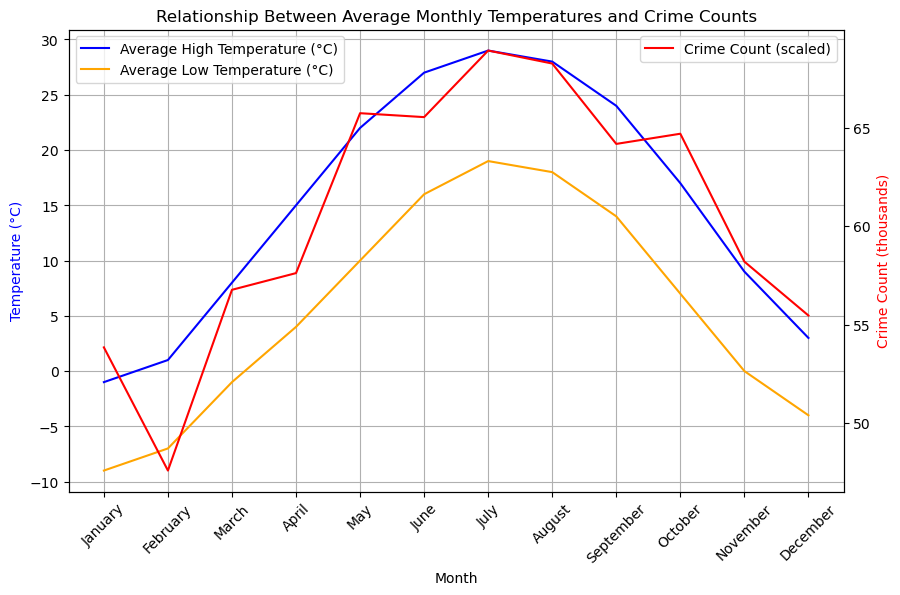

In [155]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average high temperature
ax1.plot(temp_avg['Month'], temp_avg['High_C'], label='Average High Temperature (°C)', color='blue')
ax1.plot(temp_avg['Month'], temp_avg['Low_C'], label='Average Low Temperature (°C)', color='orange')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)', color='blue')

ax2 = ax1.twinx()
# Plot crime count
ax2.plot(Chicago_month['Month'], Chicago_month['Crime_Count (k)'], label='Crime Count (scaled)', color='red')
ax2.set_ylabel('Crime Count (thousands)', color='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xticks(range(0, 12))
ax1.set_xticklabels(Chicago_month['Month'], rotation=45)
plt.title('Relationship Between Average Monthly Temperatures and Crime Counts')
ax1.grid(True)

plt.show()

The graph above illustrates the average temperatures observed across the months from 2010 to 2019, also with the total counts of reported crimes spanning from 2002 to 2023, categorized by months. A notable observation is the apparent correlation between temperature fluctuations and the frequency of reported crimes. Throughout the analyzed period, it is discernible that crime occurrences peak during the warmer months, with July exhibiting the highest incidence, while February consistently records the lowest. Furthermore, the graph indicates a general trend of rising crime rates as temperatures ascend, which suggests that warmer weather tends to coincide with increased outdoor activities and greater social interaction. 

In [144]:
arrest_rate = chicago_crime_clean.pivot_table(index='Month', columns='Arrest', aggfunc='size', fill_value=0)
arrest_rate.columns = ['Arrested (False)', 'Arrested (True)']
arrest_rate['Arrest_Rate (%)'] = (arrest_rate['Arrested (True)'] / (arrest_rate['Arrested (False)'] + 
                                                                              arrest_rate['Arrested (True)'])) * 100
arrest_rate.reset_index()

,Month,Arrested (False),Arrested (True),Arrest_Rate (%)
0,January,391996,146480,27.202698
1,February,339643,136297,28.637433
2,March,412945,154756,27.260125
3,April,425288,150888,26.187831
4,May,488767,168589,25.646529
5,June,494290,161074,24.577792
6,July,522259,166898,24.217704
7,August,514577,167989,24.611393
8,September,481597,160166,24.957188
9,October,487189,159741,24.692161


The "arrest_rate" table offers a detailed breakdown of successful and failed arrests, categorized by months, providing a comprehensive view of law enforcement activities over the specified timeframe. Different from the previous part, here, they are grouped by month to see how the arrest rate would relate to the temperature after plotting.

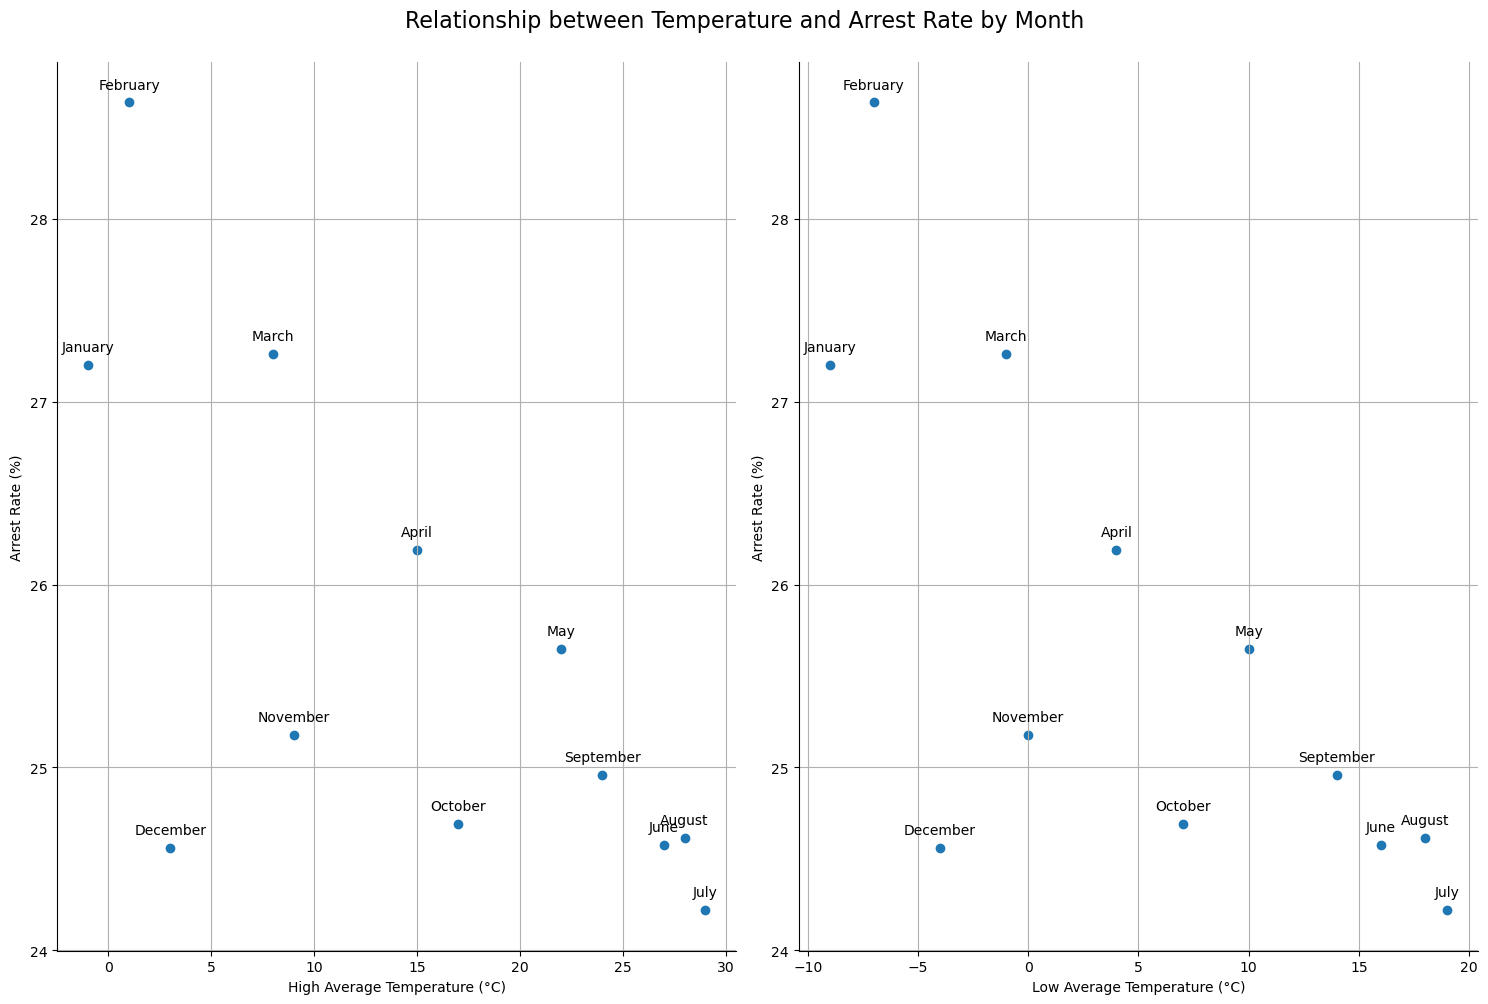

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].scatter(temp_avg['High_C'], arrest_rate['Arrest_Rate (%)'])
axes[1].scatter(temp_avg['Low_C'], arrest_rate['Arrest_Rate (%)'])

axes[0].set_xlabel('High Average Temperature (°C)')
axes[1].set_xlabel('Low Average Temperature (°C)')
axes[0].set_ylabel('Arrest Rate (%)')
axes[1].set_ylabel('Arrest Rate (%)')
plt.suptitle('Relationship between Temperature and Arrest Rate by Month', fontsize=16, x=0.5, y=1)
axes[0].grid(True)
axes[1].grid(True)
for i, txt in enumerate(temp_avg['Month']):
    axes[0].annotate(txt, (temp_avg['High_C'].iloc[i], arrest_rate['Arrest_Rate (%)'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')
    axes[1].annotate(txt, (temp_avg['Low_C'].iloc[i], arrest_rate['Arrest_Rate (%)'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
plt.show()

The scatter plot above illustrates the relationship between high and low average temperatures and the arrest rate. Interestingly, despite the observation that temperature has an impact on crime counts, it appears that the month itself plays a more influential role in determining the arrest rate. In February, despite relatively lower temperatures, the arrest rate surpasses 28%, whereas in July, despite higher temperatures, the arrest rate is only around 24%. This stark contrast is puzzling, especially considering the crime counts depicted in the previous analysis. July, typically associated with warmer weather, exhibits higher crime quantities, while February, often characterized by colder temperatures, showcases lower crime counts. This suggests that factors beyond temperature, such as socioeconomic conditions, law enforcement strategies, and community dynamics, may exert greater influence on arrest rates. Overall, while the temperature may play a role in shaping criminal behaviour, its impact on arrest rates appears to be mediated by multifaceted socio-economic and institutional factors. 

## 3.5 Adding a New Dataset

### Merging with a New Dataset

In this section, I am going to enrich the analysis by integrating a new dataset that provides insights into the racial composition of each community area in Chicago. We know that Chicago is a diverse city and there are many different races in the city, such as Black, White, Asian, and Latino. The sensitive subject here is that crime and arrest rates may differ by race, but I think it is worth researching in this project.

The dataset, sourced from the American Community Survey and obtained via the Chicago Health Atlas website, offers a comprehensive view of racial distribution across the city's community areas. By incorporating variables such as Non-Hispanic White, Non-Hispanic Black, Asian, Hispanic or Latino, Native American, Pacific Islander/Native Hawaiian, and Two or more races, we gain a nuanced understanding of the diverse population landscape within Chicago.

This integration is essential as it allows us to explore potential correlations between race and crime-related variables. While acknowledging the sensitivity of this subject, it is imperative to investigate whether disparities exist in crime rates and arrest outcomes across different racial groups. By examining these relationships, we can uncover underlying socioeconomic factors. races

In [202]:
relative_path3 = os.path.join('..', 'Data', 'Chicago_race.csv')
abs_path3 = os.path.abspath(relative_path3)

# Read the CSV file
chicago_race = pd.read_csv(abs_path3)

In [220]:
chicago_race_clean = chicago_race.rename(columns={"PCT-W_2018-2022": "Non-Hispanic White (%)",
                                                  "PCT-B_2018-2022": "Non-Hispanic Black (%)",
                                                  "PCT-A_2018-2022": "Asian (%)", "PCT-H_2018-2022": "Hispanic or Latino (%)",
                                                  "PCT-P_2018-2022": "Native American (%)", "PCT-P1_2018-2022": "Native Hawaiian (%)",
                                                  "PCT-Q_2018-2022": "Two or more races (%)"})
chicago_race_clean.isnull().any(axis=0)

Layer                      True
Name                       True
GEOID                      True
Population                 True
Longitude                  True
Latitude                   True
Non-Hispanic White (%)    False
Non-Hispanic Black (%)    False
Asian (%)                 False
Hispanic or Latino (%)    False
Native American (%)       False
Native Hawaiian (%)       False
Two or more races (%)     False
dtype: bool

In [221]:
chicago_race_clean = chicago_race_clean.dropna()
chicago_race_clean.dtypes

Layer                      object
Name                       object
GEOID                     float64
Population                float64
Longitude                 float64
Latitude                  float64
Non-Hispanic White (%)     object
Non-Hispanic Black (%)     object
Asian (%)                  object
Hispanic or Latino (%)     object
Native American (%)        object
Native Hawaiian (%)        object
Two or more races (%)      object
dtype: object

In [222]:
# Change data type
chicago_race_clean['GEOID'] = chicago_race_clean['GEOID'].astype(int)
chicago_race_clean['Non-Hispanic White (%)'] = chicago_race_clean['Non-Hispanic White (%)'].astype(float)
chicago_race_clean['Non-Hispanic Black (%)'] = chicago_race_clean['Non-Hispanic Black (%)'].astype(float)
chicago_race_clean['Asian (%)'] = chicago_race_clean['Asian (%)'].astype(float)
chicago_race_clean['Hispanic or Latino (%)'] = chicago_race_clean['Hispanic or Latino (%)'].astype(float)
chicago_race_clean['Native American (%)'] = chicago_race_clean['Native American (%)'].astype(float)
chicago_race_clean['Native Hawaiian (%)'] = chicago_race_clean['Native Hawaiian (%)'].astype(float)
chicago_race_clean['Two or more races (%)'] = chicago_race_clean['Two or more races (%)'].astype(float)
# Combine the last three columns into one column
chicago_race_clean['Other Races (%)'] = chicago_race_clean.apply(lambda row: row['Native American (%)'] + 
                                                                 row['Native Hawaiian (%)'] + row['Two or more races (%)'], axis=1)
# Drop useless columns
chicago_race_clean = chicago_race_clean.drop(['Layer', 'Name', 'Native American (%)', 'Native Hawaiian (%)', 
                                              'Two or more races (%)'], axis=1)
# Keep three decimal
chicago_race_clean['Non-Hispanic White (%)'] = chicago_race_clean['Non-Hispanic White (%)'].round(3)
chicago_race_clean['Non-Hispanic Black (%)'] = chicago_race_clean['Non-Hispanic Black (%)'].round(3)
chicago_race_clean['Asian (%)'] = chicago_race_clean['Asian (%)'].round(3)
chicago_race_clean['Hispanic or Latino (%)'] = chicago_race_clean['Hispanic or Latino (%)'].round(3)
chicago_race_clean['Other Races (%)'] = chicago_race_clean['Other Races (%)'].round(3)

In [224]:
chicago_race_clean.describe()

,GEOID,Population,Longitude,Latitude,Non-Hispanic White (%),Non-Hispanic Black (%),Asian (%),Hispanic or Latino (%),Other Races (%)
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,35570.857143,-87.675184,41.839498,27.319208,36.457883,6.469766,26.964701,2.402714
std,22.371857,23354.909949,0.070120,0.099256,25.775990,37.990966,10.318573,27.318641,1.465437
min,1.000000,2514.000000,-87.893699,41.660137,0.239000,0.035000,0.000000,0.519000,0.084000
25%,20.000000,18633.000000,-87.721558,41.763251,4.253000,3.368000,0.560000,5.255000,1.215000
50%,39.000000,29899.000000,-87.669062,41.829927,14.676000,13.929000,2.377000,14.835000,2.152000
75%,58.000000,45141.000000,-87.620344,41.927275,46.676000,79.322000,9.274000,46.021000,3.518000
max,77.000000,103048.000000,-87.534907,42.009630,83.973000,96.248000,64.643000,92.191000,5.900000


The table above shows statistical data about the new dataset. As we can see, in whole community areas of Chicago, the Black population is the largest since its mean is around 36.5%. Also, the average population of whites and Latinos is about the same, with 27.3% and 27% respectively. However, no matter which race, it seems like there exists one area where there is almost all people of that race and another area where there is almost no people of that race by looking for the max and min in the table.

In the next step, I will merge the data and plot some graphs to get a clear and deep observation.

## 3.6 Coclusion

In this research, I am trying to analyze whether crime types influence arrest rates in different community areas of Chicago from 2002 to 2023. With our statistical and visual analysis in Project 1, we see that over time, the number of crimes went down year by year and the arrest rate went down year by year. In addition, from the end analysis, we know that in 39 out of 77 regions, the most frequent type of crime was theft, but with our initial exploration, the number of people who were not arrested for theft was also the highest, even though it does not have the lowest arrest rate. Also, we found that the number of types of crime in an area affects the arrest rate in that area. Area 26 has the highest arrest rate at around 43%, while Area 12 only has about 10.4%. Based on crime types, years, and community areas, the arrest rate has a large range with a minimum of 0% and a maximum of 100%. The average arrest rate is only around 19.3%, which implies in a significant portion of the data, arrests were made for approximately 19.3% of reported incidents. This indicates considerable variability in law enforcement outcomes across different crime types, years, and community areas.

In Project 2, I divide primary types into two groups, violent and non-violent crimes, and then plot their arrest rates over time. As we can see, violent crimes range from 20% to 25%, but non-violent crimes have a large change, also, both of them have a critical point in 2008. Notably, while certain offenses such as prostitution and narcotics consistently exhibit high arrest rates throughout the years, others like other narcotic violations only show peaks in specific periods, such as 2002 to 2004. These observations suggest a correlation between the detection of specific criminal activities and subsequent arrest rates.

I merge a per capita income new dataset and create maps to show the relationship between some variables and Chicago community areas. Firstly, we found that West Garfield Park (area 26) has the highest arrest rate, while Forest Glen (area 12) is the opposite. Also, the north side of Chicago has lower arrest rates than the south side of Chicago. In addition, I show the difference in the number of crimes per area. On that map, Austin (area 25) is the most, and we could know that crime counts and arrest rates have some correlation. Moreover, since we have explored prostitution crime type has the highest arrest rate in Project 1, I create a map to show how it is distributed in each area, and then we found that Near North Side (area 8) has higher incidents but lower arrest rate. Lastly, I use the new dataset to show per capita income change over time. Near North Side (area 8) always be the highest, which might relate to why this area has many crime incidents but a lower arrest rate.

In conclusion, the data highlights the complexity and diversity of arrest outcomes in the context of crime types, years, and community areas. Therefore, we will keep further analysis and explore how community areas and crime types influence arrest rates over time. And why high per capita income areas do not have higher arrest rates, since they should have good equipment, manpower and environment to catch criminals.

## References

1. Ousey, Graham C. (2000). “Explaining Regional and Urban Variation in Crime: A Review of Research.” Office of Justice Programs, https://www.ojp.gov/library/publications/explaining-regional-and-urban-variation-crime-review-research.

2. Braga, A. A., Hureau, D. M., & Papachristos, A. V. (2011). The Relevance of Micro Places to Citywide Robbery Trends: A Longitudinal Analysis of Robbery Incidents at Street Corners and Block Faces in Boston. Journal of Research in Crime and Delinquency, 48(1), 7-32. https://doi.org/10.1177/0022427810384137

3. Wilson, W. J. (1987). The truly disadvantaged: The inner city, the underclass, and public policy. University of Chicago Press.